In [2]:
import arviz as az
import pymc as pm
import numpy as np
import pandas as pd
import preliz as pz
from scipy.stats import linregress
from scipy.special import expit as logistic
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
import xarray as xr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('arviz-doc')

# Linear Regression
- Central ideia is to add predictor variables to estimate the mean $$\mu = \alpha + \beta X$$ $$Y \sim N(\mu,\sigma)$$
- Linear relationship between $X$ and $Y$, but is non-deterministic, because of noise term $\sigma$
- Parameters
  - Typical assumptions: Are independent
  - Normally $\alpha$ and $\beta$ are assigned to normal distributions
  - $\sigma$ must be a positive, so halfnormal, exponential

## Linear model (Normal distribution)

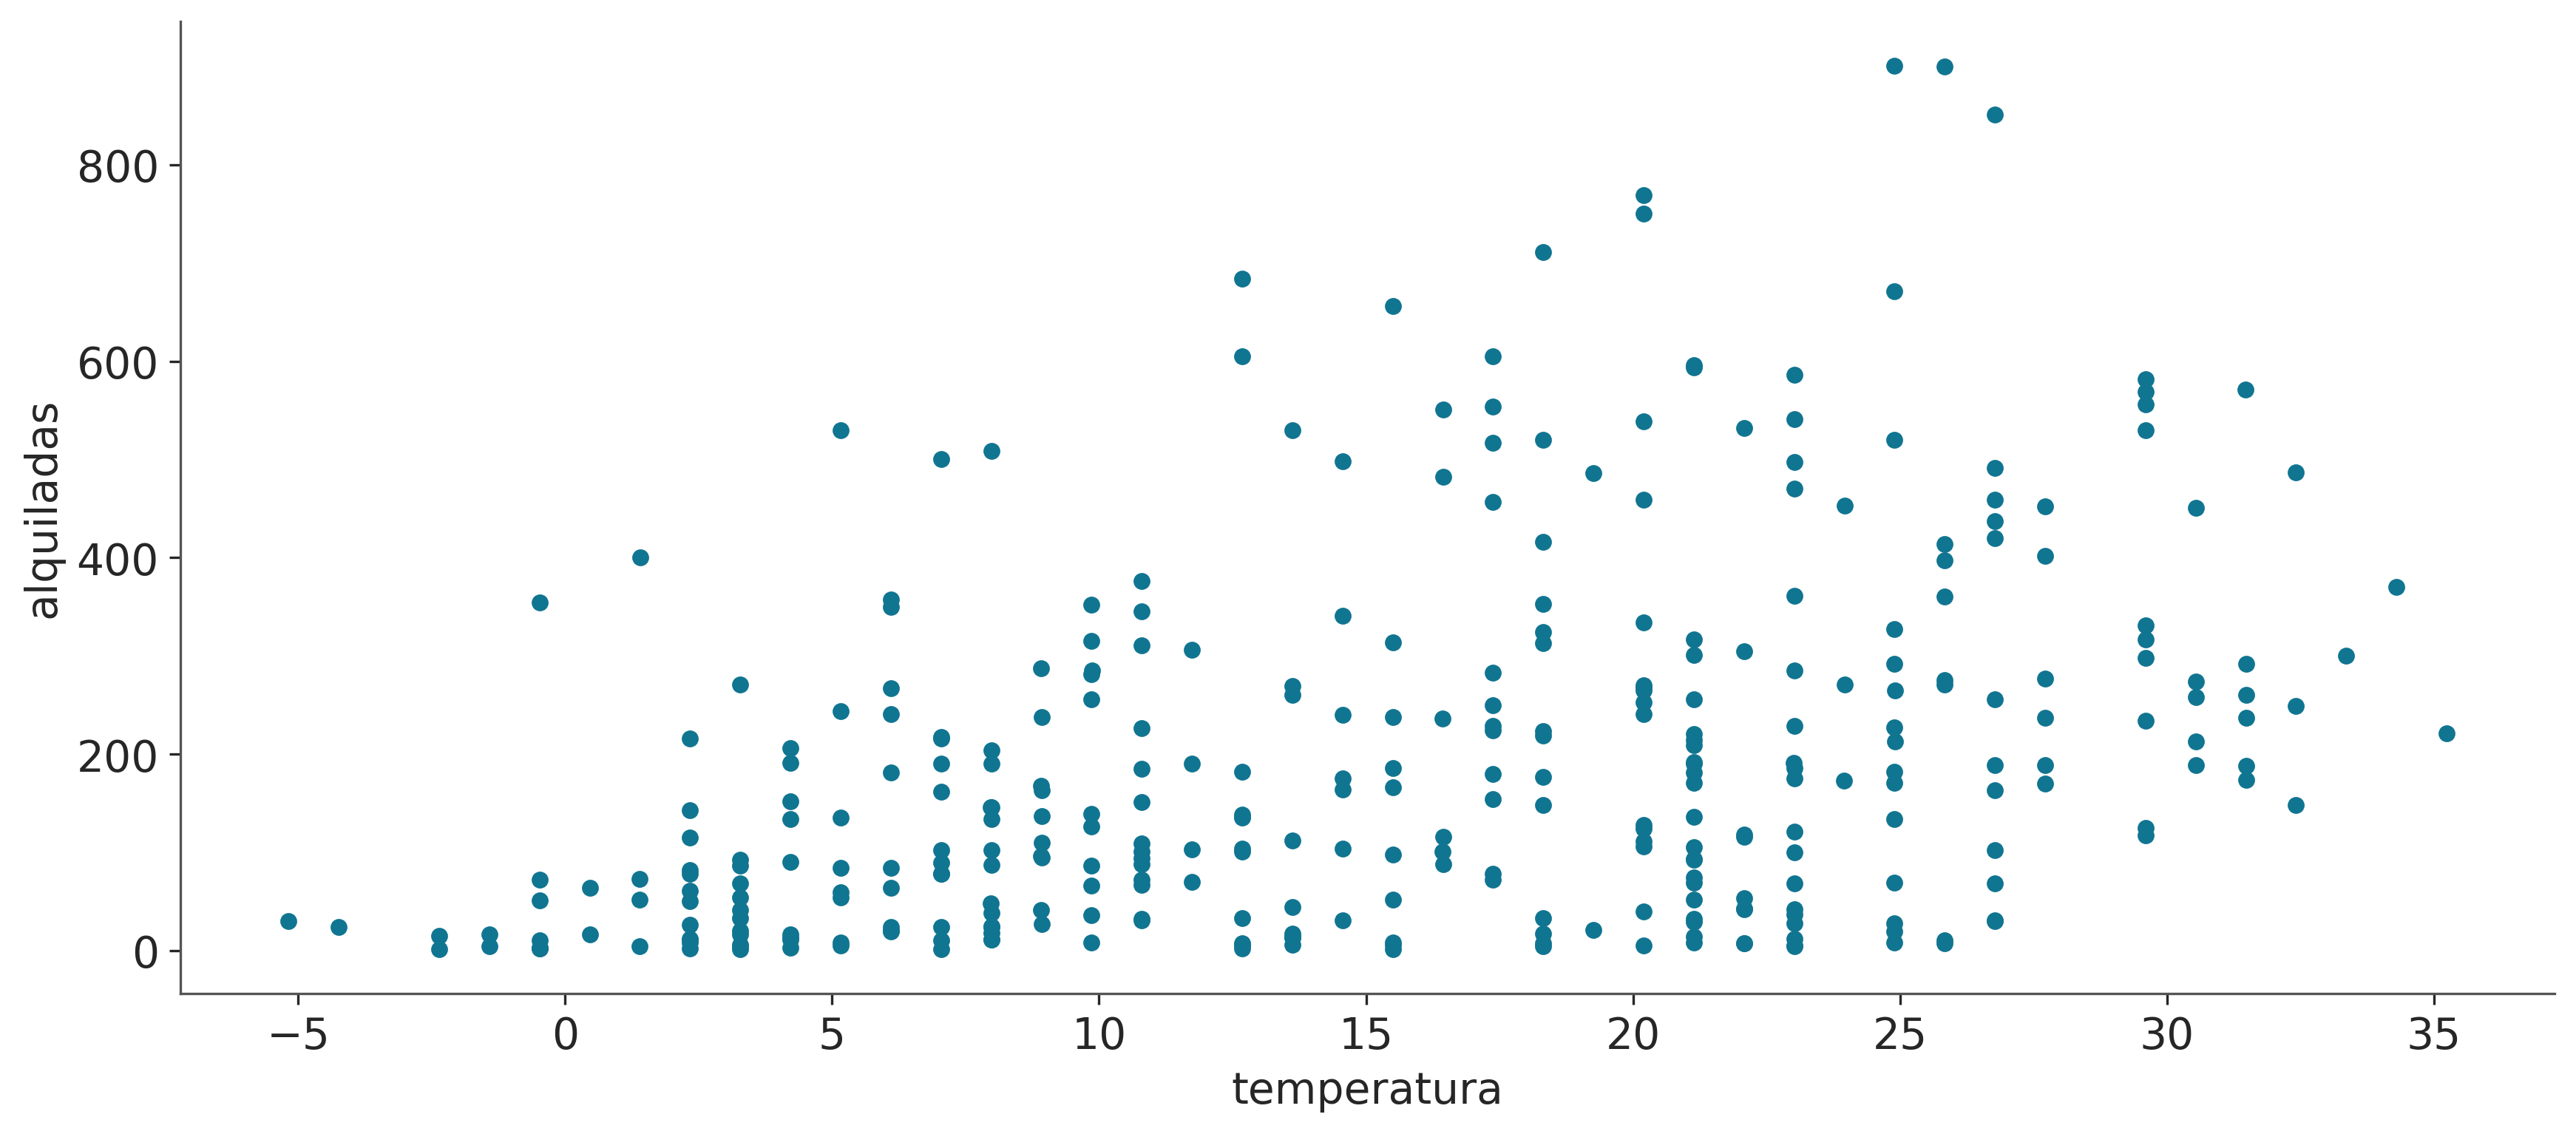

In [3]:
bike = pd.read_csv("data/bicis.csv")
#alquiladas is rented
bike.plot(x="temperatura", y="alquiladas", kind="scatter");

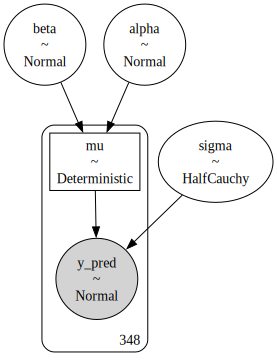

In [4]:
with pm.Model() as bike_model:
    alpha = pm.Normal('alpha',mu=0,sigma=100) # intercept
    beta = pm.Normal('beta',mu=0,sigma=10) # slope
    sigma = pm.HalfCauchy('sigma',10) # noise
    mu = pm.Deterministic('mu',alpha + beta*bike.temperatura)
    _ = pm.Normal('y_pred',mu=mu,sigma=sigma,observed=bike.alquiladas)
pm.model_to_graphviz(bike_model)

In [5]:
with bike_model:
    idata_bm = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


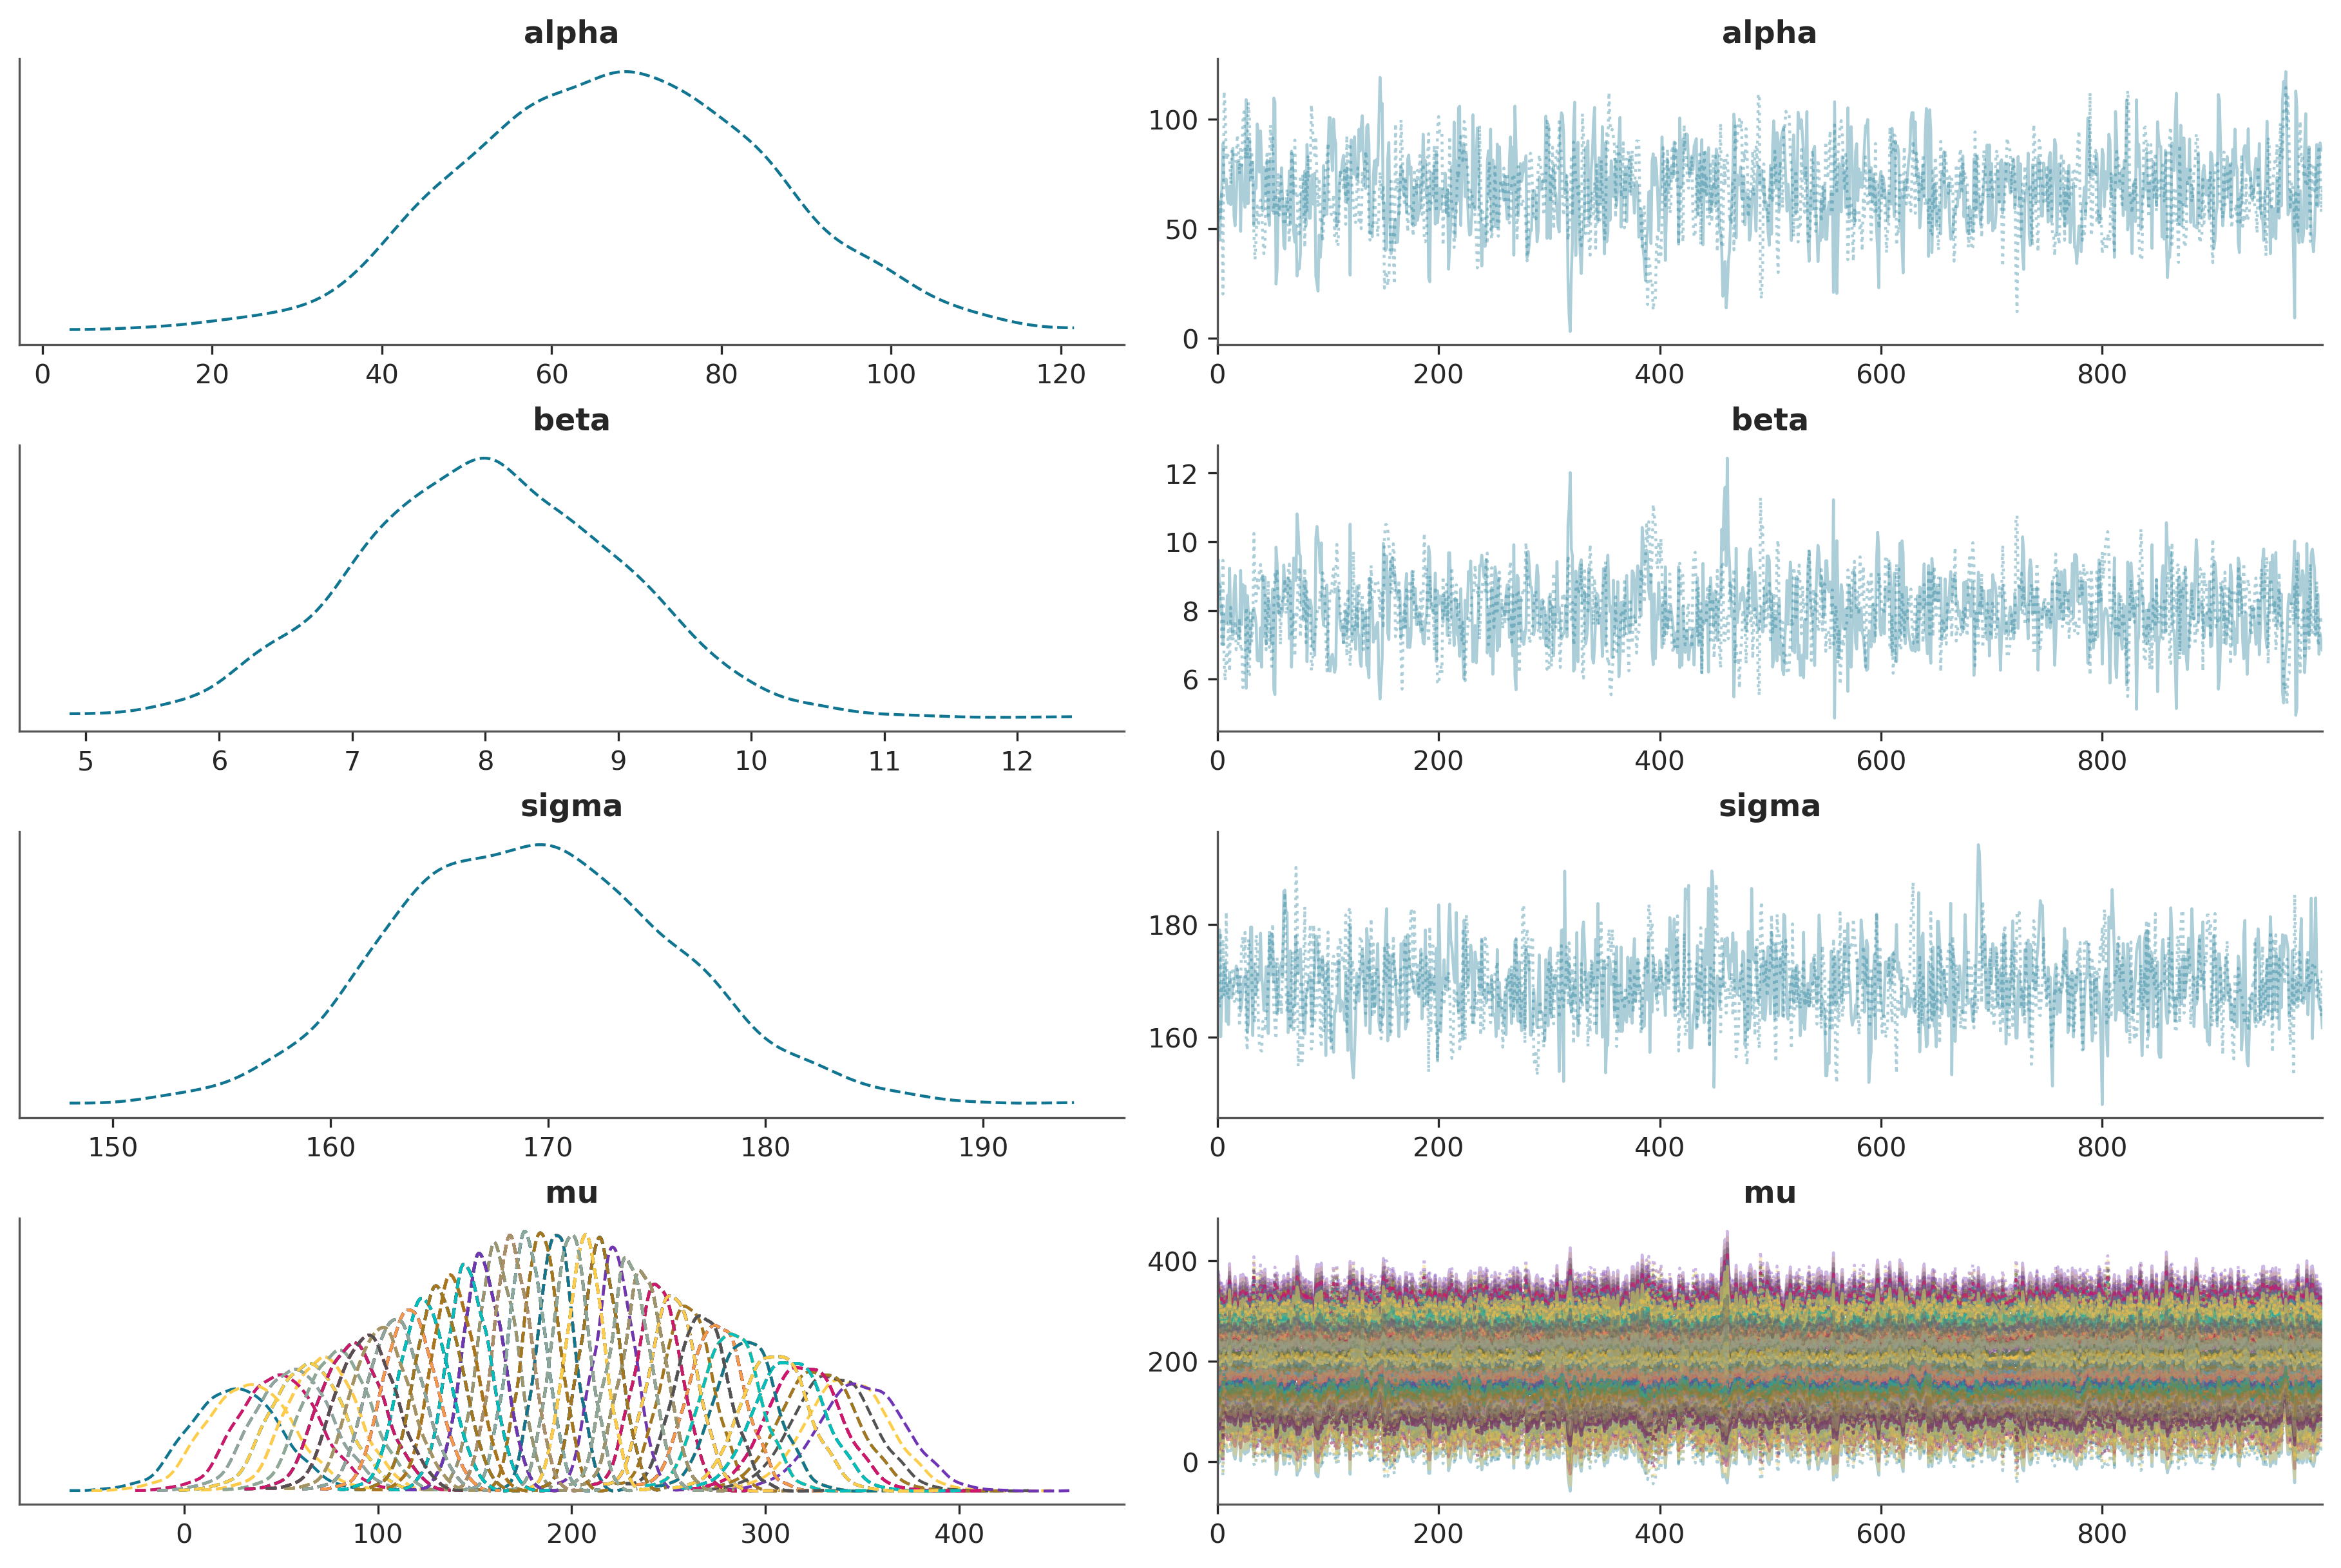

In [6]:
az.plot_trace(idata_bm, combined=True);  

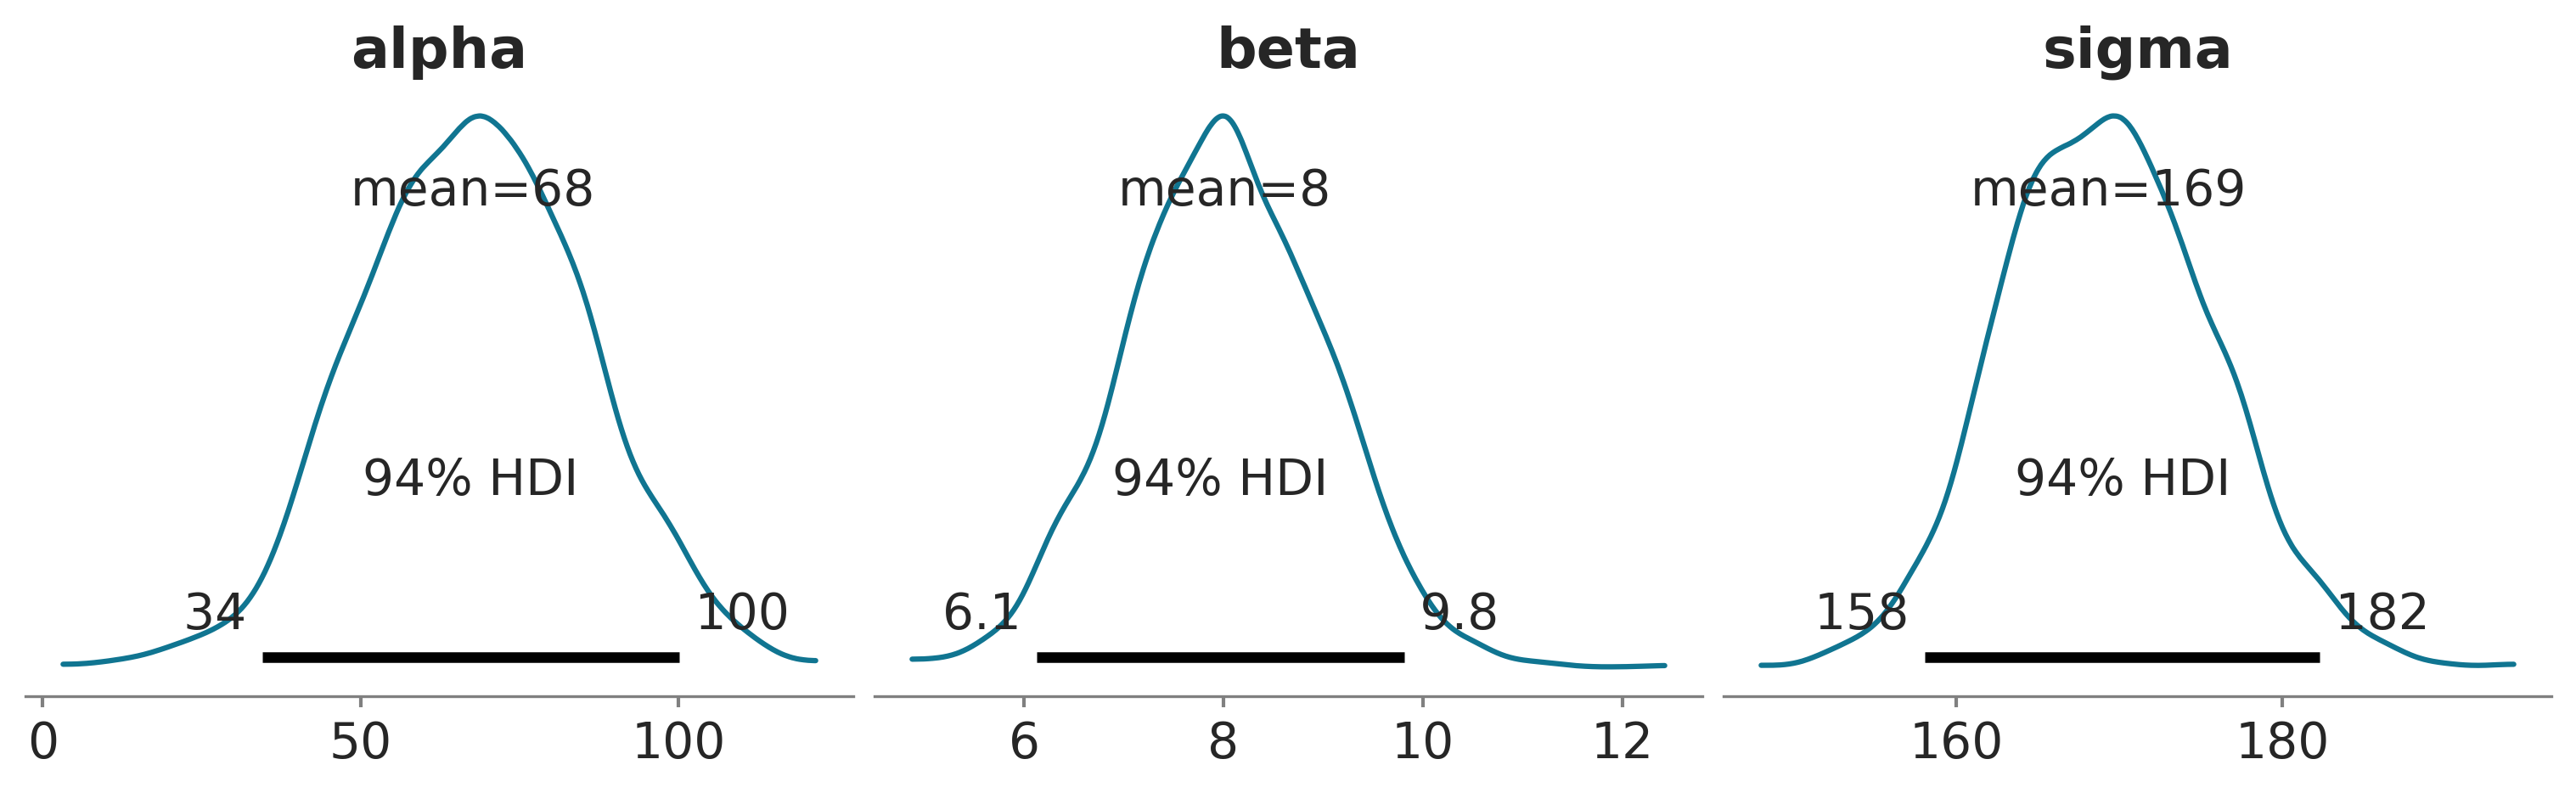

In [7]:
az.plot_posterior(idata_bm, var_names=['~mu'], figsize=(10, 3));

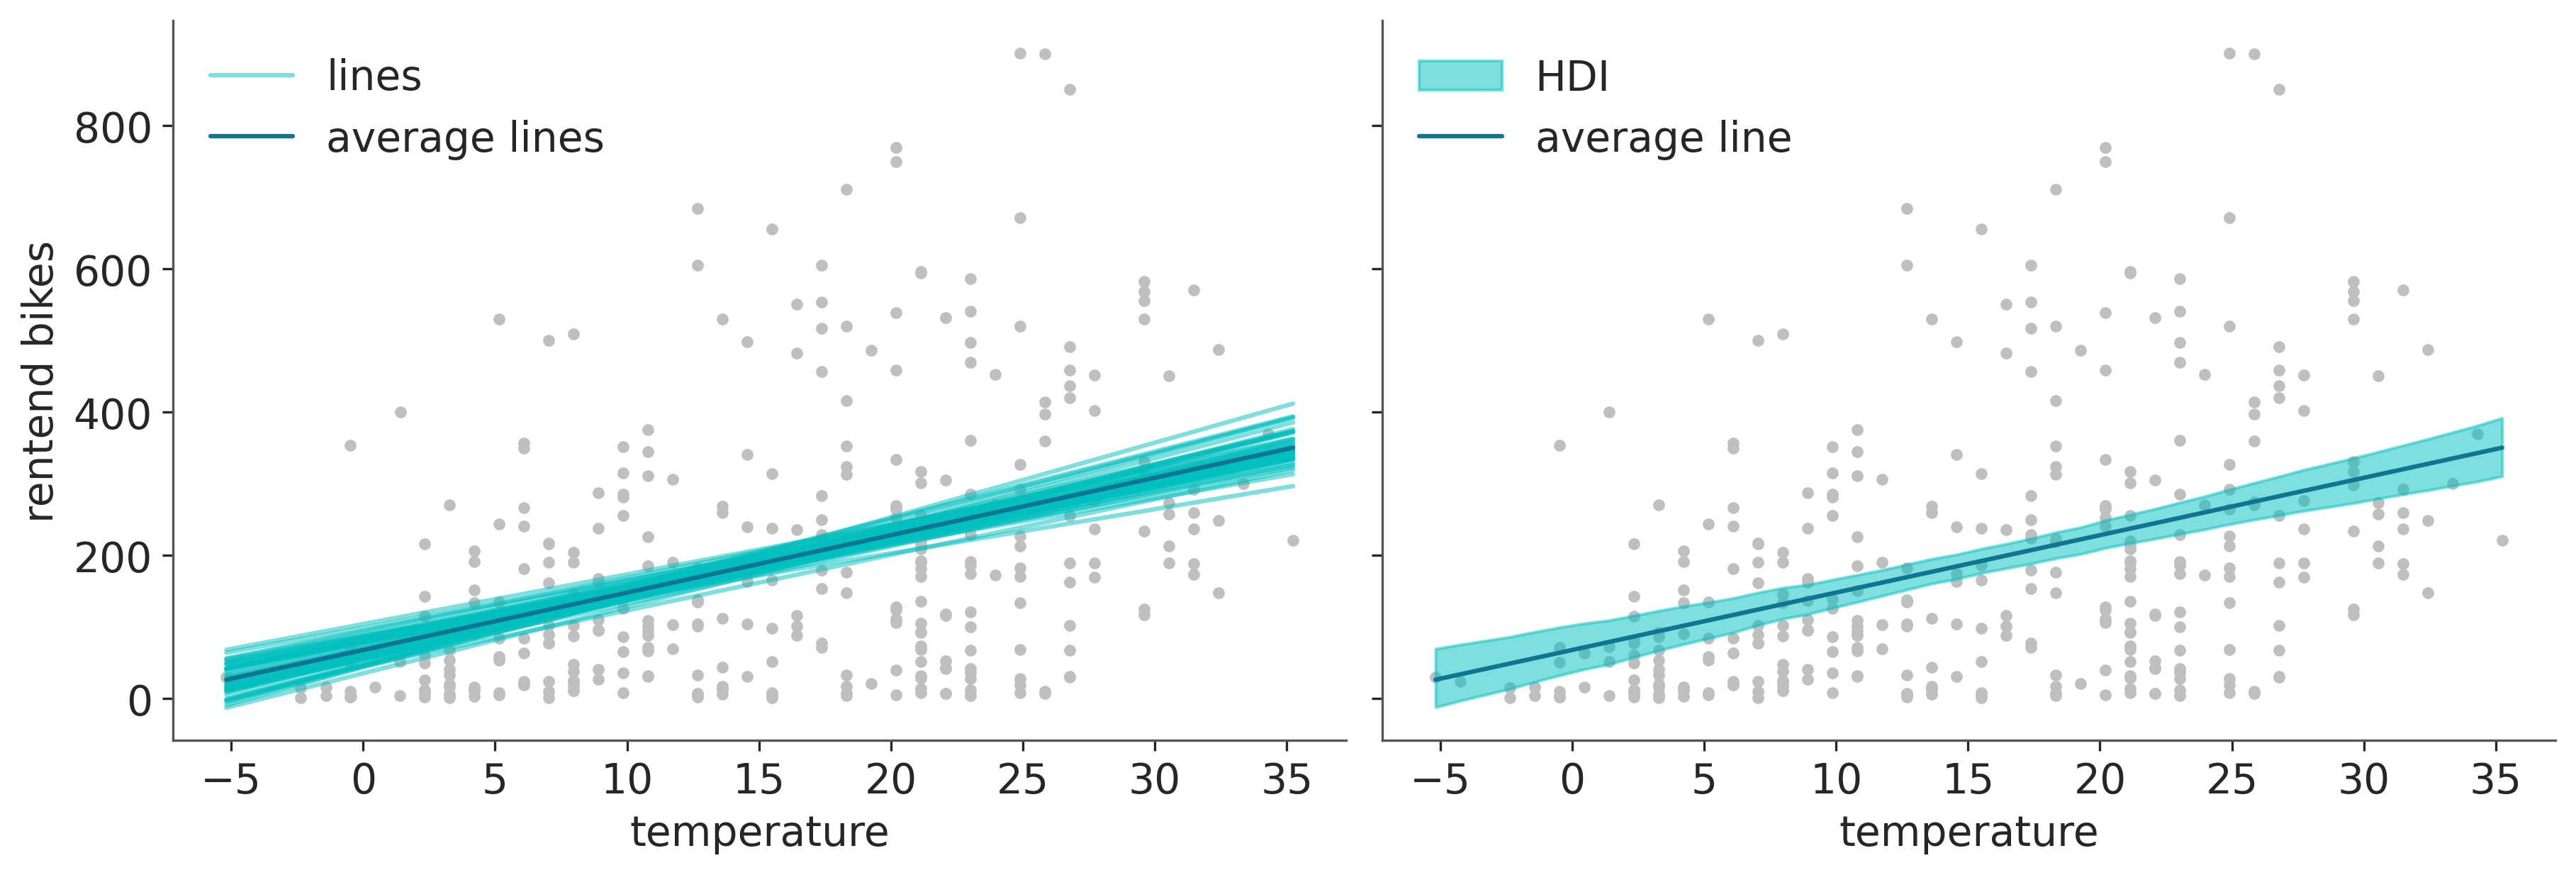

In [8]:
posterior = az.extract(idata_bm, num_samples=50) # Sample 50 points from the posterior
x_plot = xr.DataArray(np.linspace(bike.temperatura.min(), bike.temperatura.max(), 50), dims="plot_id") # x dim plot
average_line = posterior['alpha'].mean() + posterior['beta'].mean() * x_plot # Line as the average of the posterior
lines = posterior['alpha'] + posterior['beta'] * x_plot # Lines for each posterior sample
hdi_lines = az.hdi(idata_bm.posterior['mu']) # hdi for the posterior 


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(bike.temperatura, bike.alquiladas,  '.', color="0.75",  zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c='C1', alpha=0.5, label='lines')
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, average_line, c='C0', label='average lines')
axes[0].set_xlabel('temperature')
axes[0].set_ylabel('rentend bikes')
axes[0].legend()

axes[1].plot(bike.temperatura, bike.alquiladas, '.', color="0.75",  zorder=-3)
idx = np.argsort(bike.temperatura.values)
axes[1].fill_between(bike.temperatura[idx], hdi_lines["mu"][:,0][idx], hdi_lines["mu"][:,1][idx],
                     color="C1", label='HDI', alpha=0.5)
axes[1].plot(x_plot, average_line, c='C0', label='average line')
axes[1].set_xlabel('temperature')
axes[1].legend();

In [9]:
pm.sample_posterior_predictive(idata_bm, model=bike_model, extend_inferencedata=True, random_seed=123)

Sampling: [y_pred]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

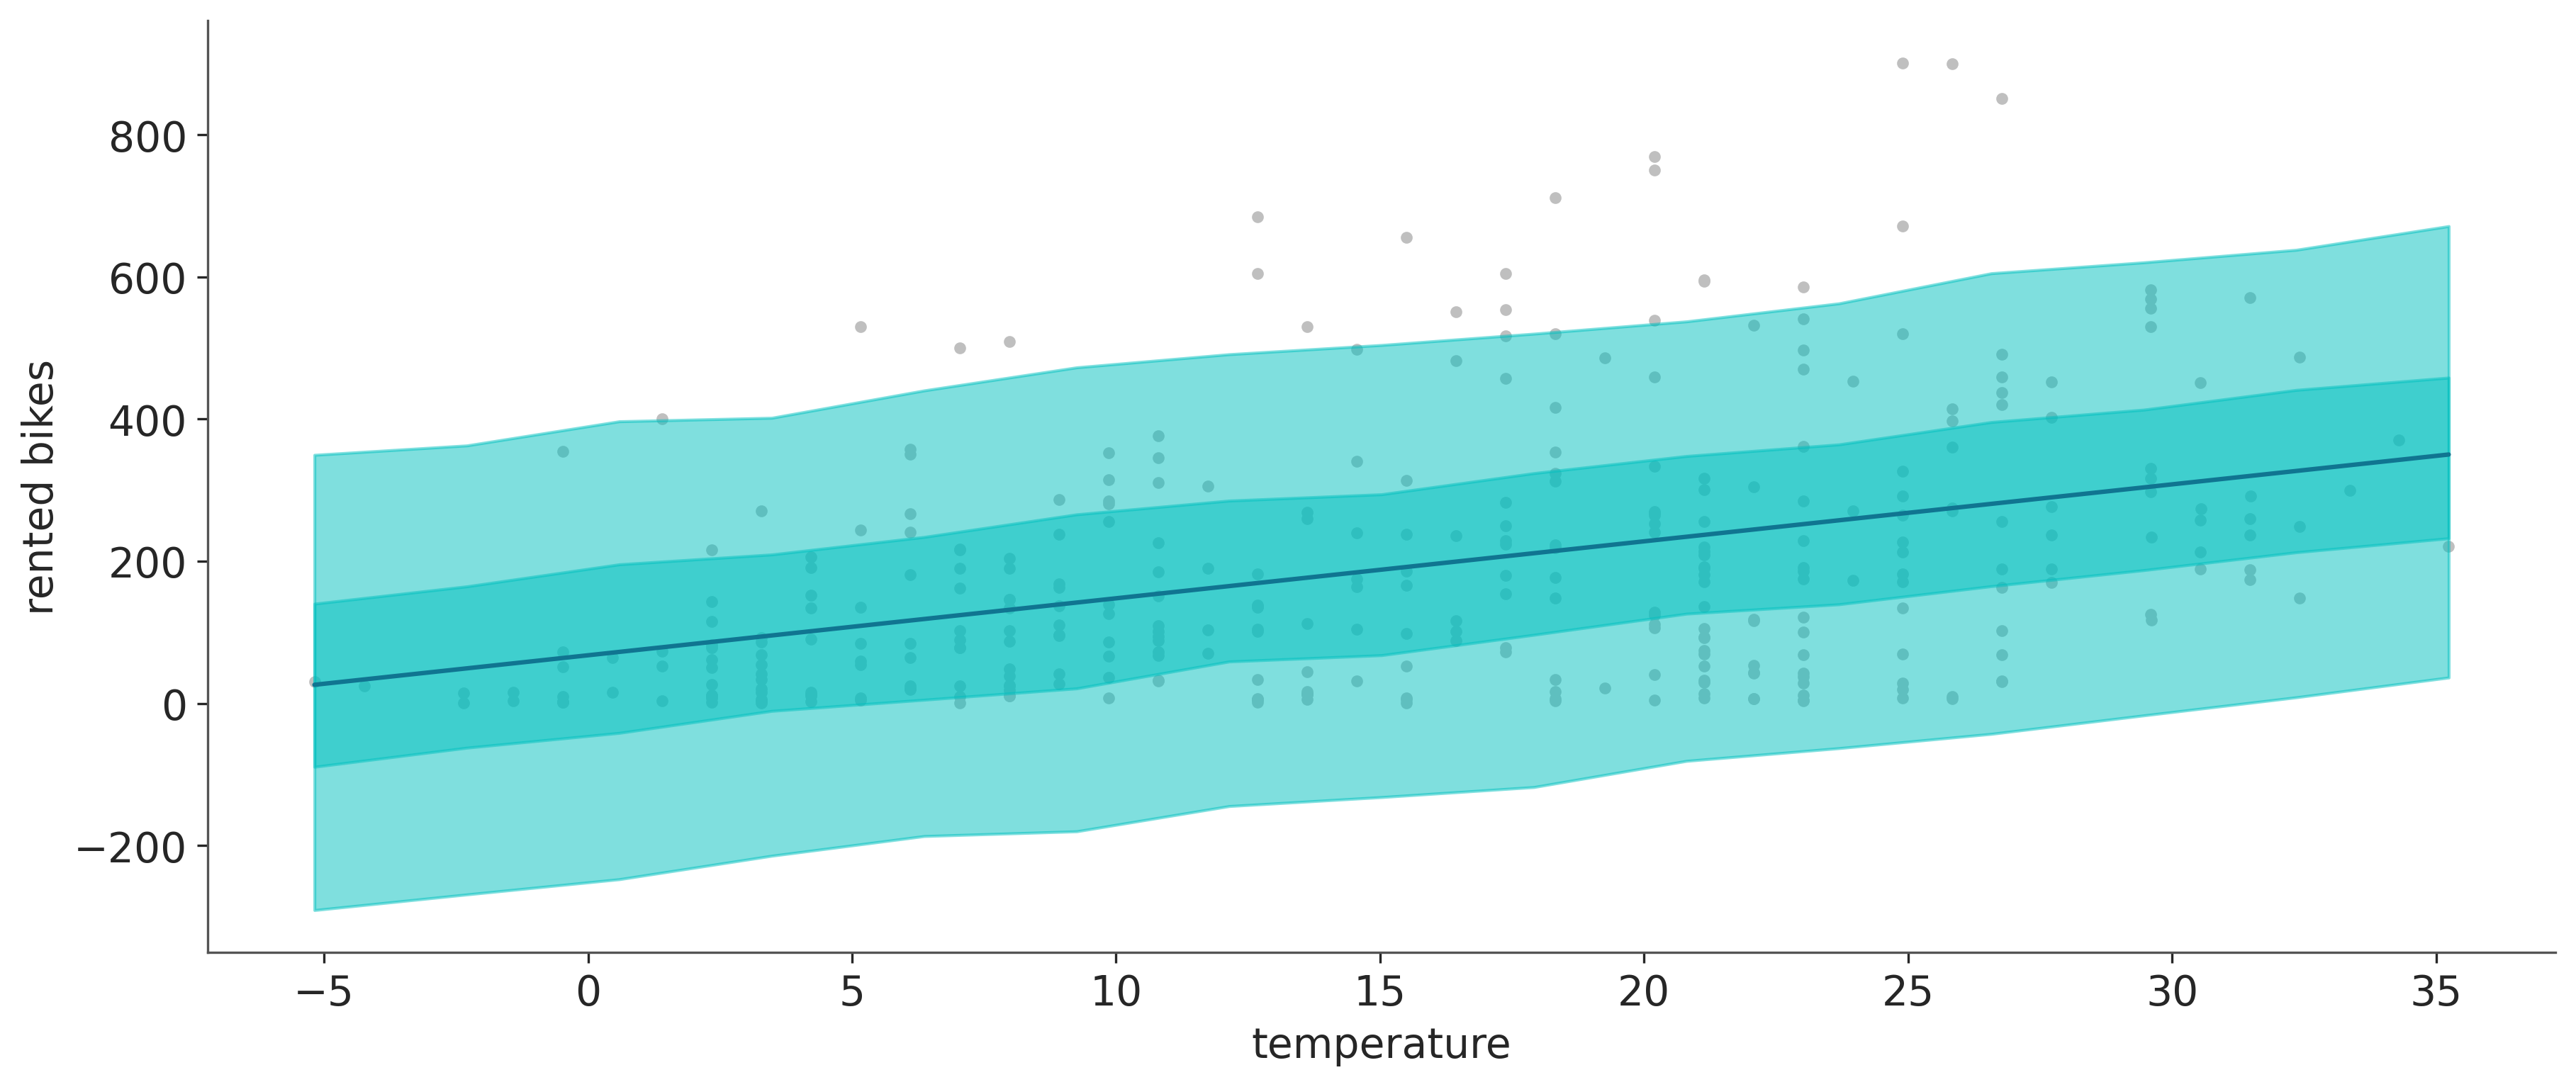

In [10]:
average_line = idata_bm.posterior['mu'].mean(("chain", "draw")) # Mean across chains and draws
idx = np.argsort(bike.temperatura.values) # Sorted indexes
x = np.linspace(bike.temperatura.min(), bike.temperatura.max(), 15) # 15 linespaced points between min and max 
y_pred_q = idata_bm.posterior_predictive['y_pred'].quantile([0.03, 0.97, 0.25, 0.75], dim=['chain', 'draw']) # Quantiles
y_hat_bounds = iter([PchipInterpolator(bike.temperatura.values[idx], y_pred_q[i][idx])(x) for i in range(4)])

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bike.temperatura, bike.alquiladas, '.', color="0.75",  zorder=-3)
ax.plot(bike.temperatura[idx], average_line[idx], c='C0')

for lb, ub in zip(y_hat_bounds, y_hat_bounds): 
    ax.fill_between(x,
                    lb, ub,
                    color="C1", alpha=0.5)


ax.set_xlabel('temperature')
ax.set_ylabel('rented bikes');

- Problems with above approach:
  - Linear regression can predict negative values (problem on sales)
  - Solution: Using other distributions

## Generalizing Linear Models
- Extension to linear regression $$\mu = \alpha + \beta X$$ $$Y \sim \phi(f(\mu),\theta)$$ where
- $\phi$ represents an arbitrary distribution(one of the exponential family)
- $\theta$ represents any auxiliary parameters
- $f$ is the reverse link function

## Linear model to count data
- Number of bikes is discrete and equal or greater to $0$.
- Poisson distribution and Negative Binomial
  - Poisson: Mean and variance are controlled by the same parameter and are the same
  - In cases where this might not be the case, Negative Binomial is used as alternative
- **Negative Binomial**
  - $\mu$: mean
  - $\alpha$: Dispersion parameter
  - Variance is defined as $\mu + \frac{\mu^2}{\alpha}$. Higher the $\alpha$, smaller the variance
  - Reverse link function: $exp$

In [11]:
with pm.Model() as nbinom_model:
    alpha = pm.Normal('alpha',mu=0,sigma=100) # intercept
    beta = pm.Normal('beta',mu=0,sigma=10) # slope
    dispersion = pm.HalfCauchy('sigma',10) # dispersion
    mu = pm.Deterministic('mu',pm.math.exp(alpha + beta*bike.temperatura)) # Reverse link function on mu
    y_pred = pm.NegativeBinomial('y_pred',mu=mu,alpha=dispersion,observed=bike.alquiladas)
    idata_neg = pm.sample(random_seed=123)
    idata_neg.extend(pm.sample_posterior_predictive(idata_neg, random_seed=123))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y_pred]


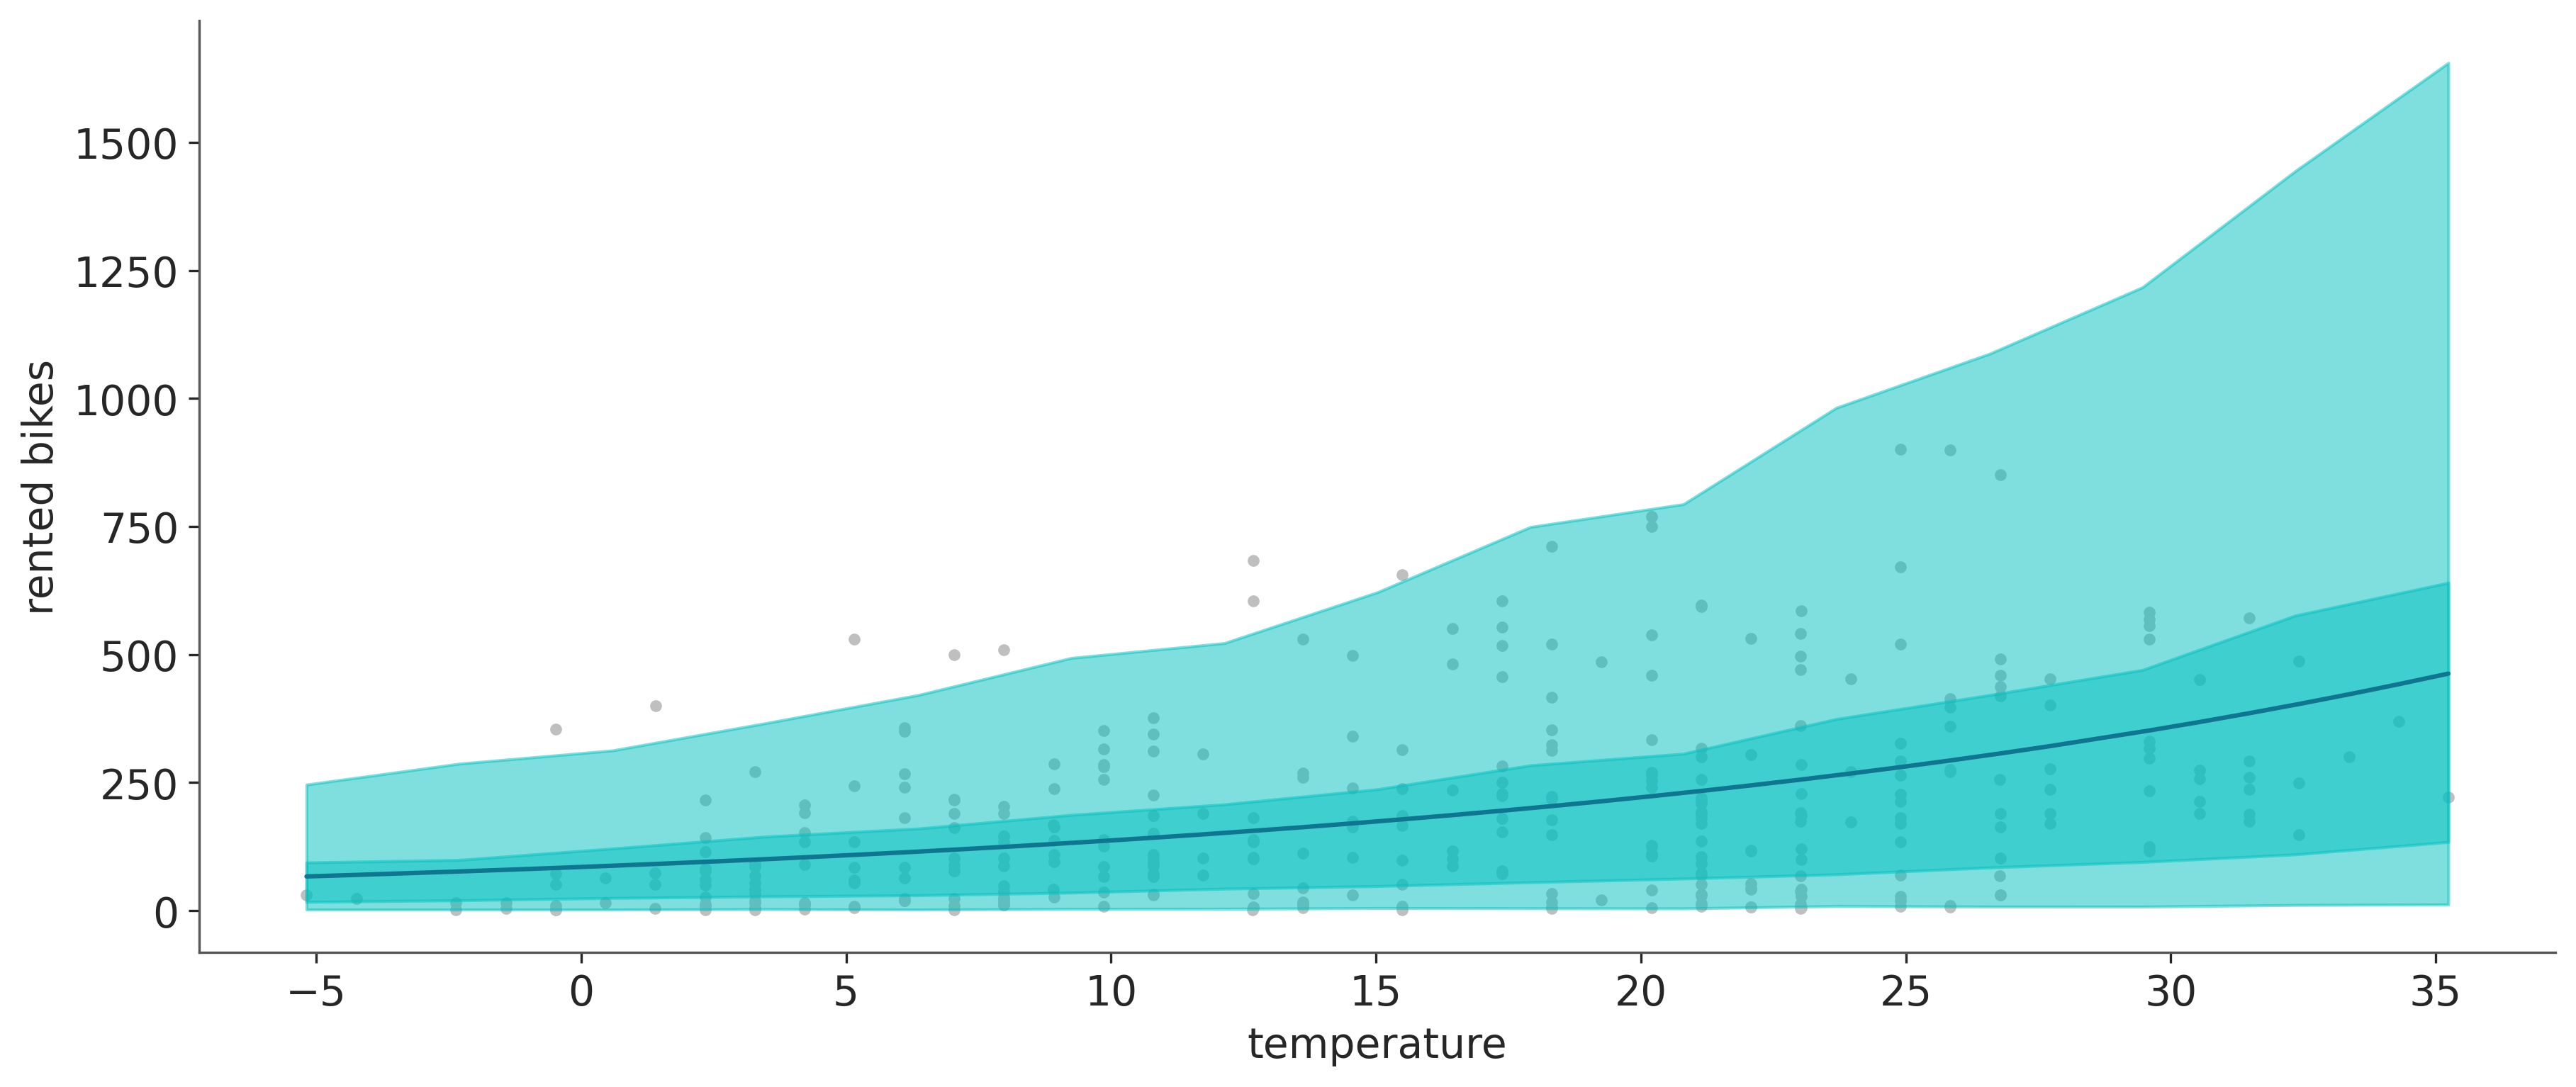

In [12]:
linea_media = idata_neg.posterior['mu'].mean(("chain", "draw"))
idx = np.argsort(bike.temperatura.values)
x = np.linspace(bike.temperatura.min(), bike.temperatura.max(), 15)
y_pred_q = idata_neg.posterior_predictive['y_pred'].quantile([0.03, 0.97, 0.25, 0.75], dim=['chain', 'draw'])
y_hat_bounds = iter([PchipInterpolator(bike.temperatura.values[idx], y_pred_q[i][idx])(x) for i in range(4)])

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bike.temperatura, bike.alquiladas, '.', color="0.75", zorder=-3)
ax.plot(bike.temperatura[idx], linea_media[idx], c='C0')

for lb, ub in zip(y_hat_bounds, y_hat_bounds): 
    ax.fill_between(x,
                    lb, ub,
                    color="C1", alpha=0.5)

ax.set_xlabel('temperature')
ax.set_ylabel('rented bikes');

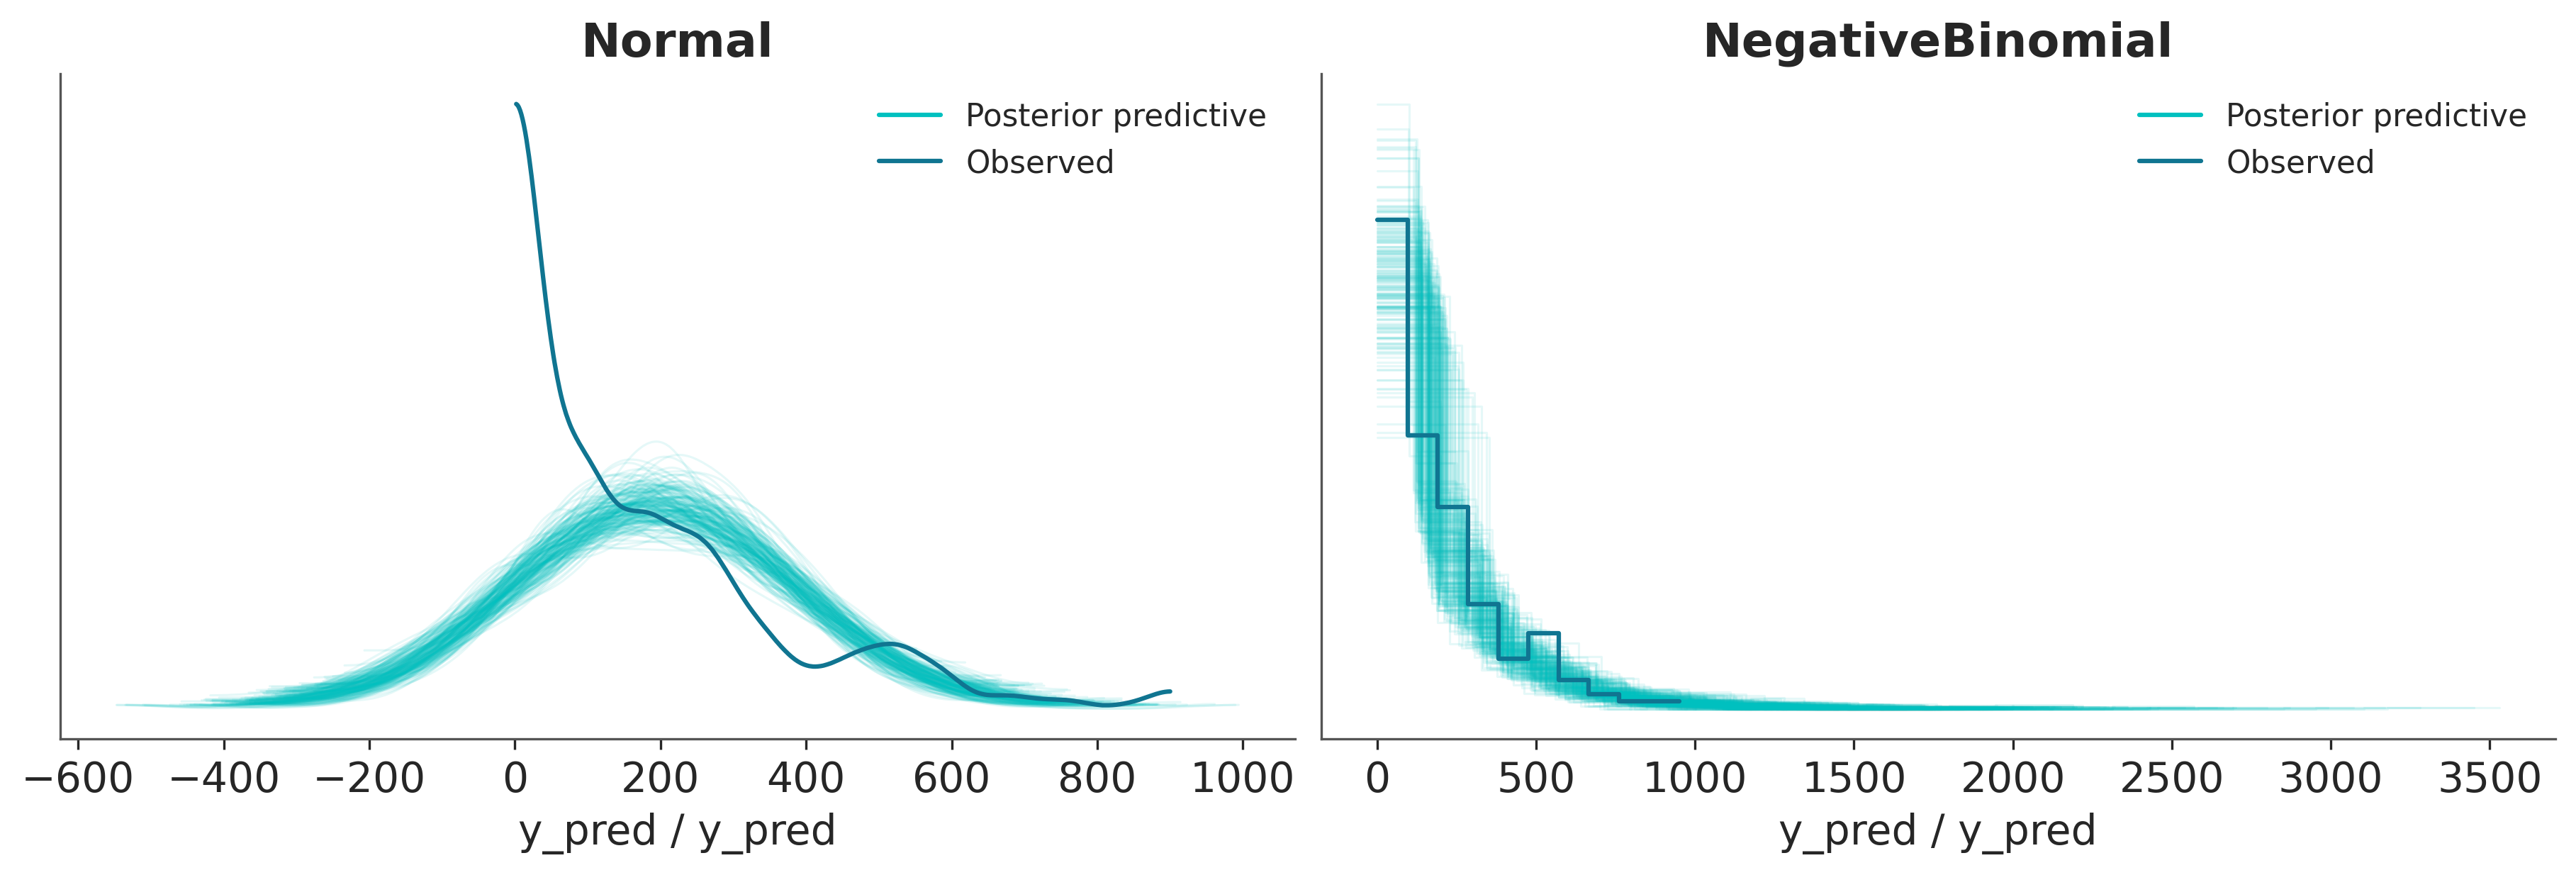

In [13]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_ppc(idata_bm,  num_pp_samples=200,  alpha=0.1, colors=["C1", "C0", "C0"], ax=ax[0], mean=False)
az.plot_ppc(idata_neg, num_pp_samples=200,  alpha=0.1, colors=["C1", "C0", "C0"], ax=ax[1], mean=False)
ax[0].set_title("Normal")
ax[1].set_title("NegativeBinomial");

## Robust Regression
- Student's T distribution has heavier tails than the normal -> Less influenced by outliers
- 

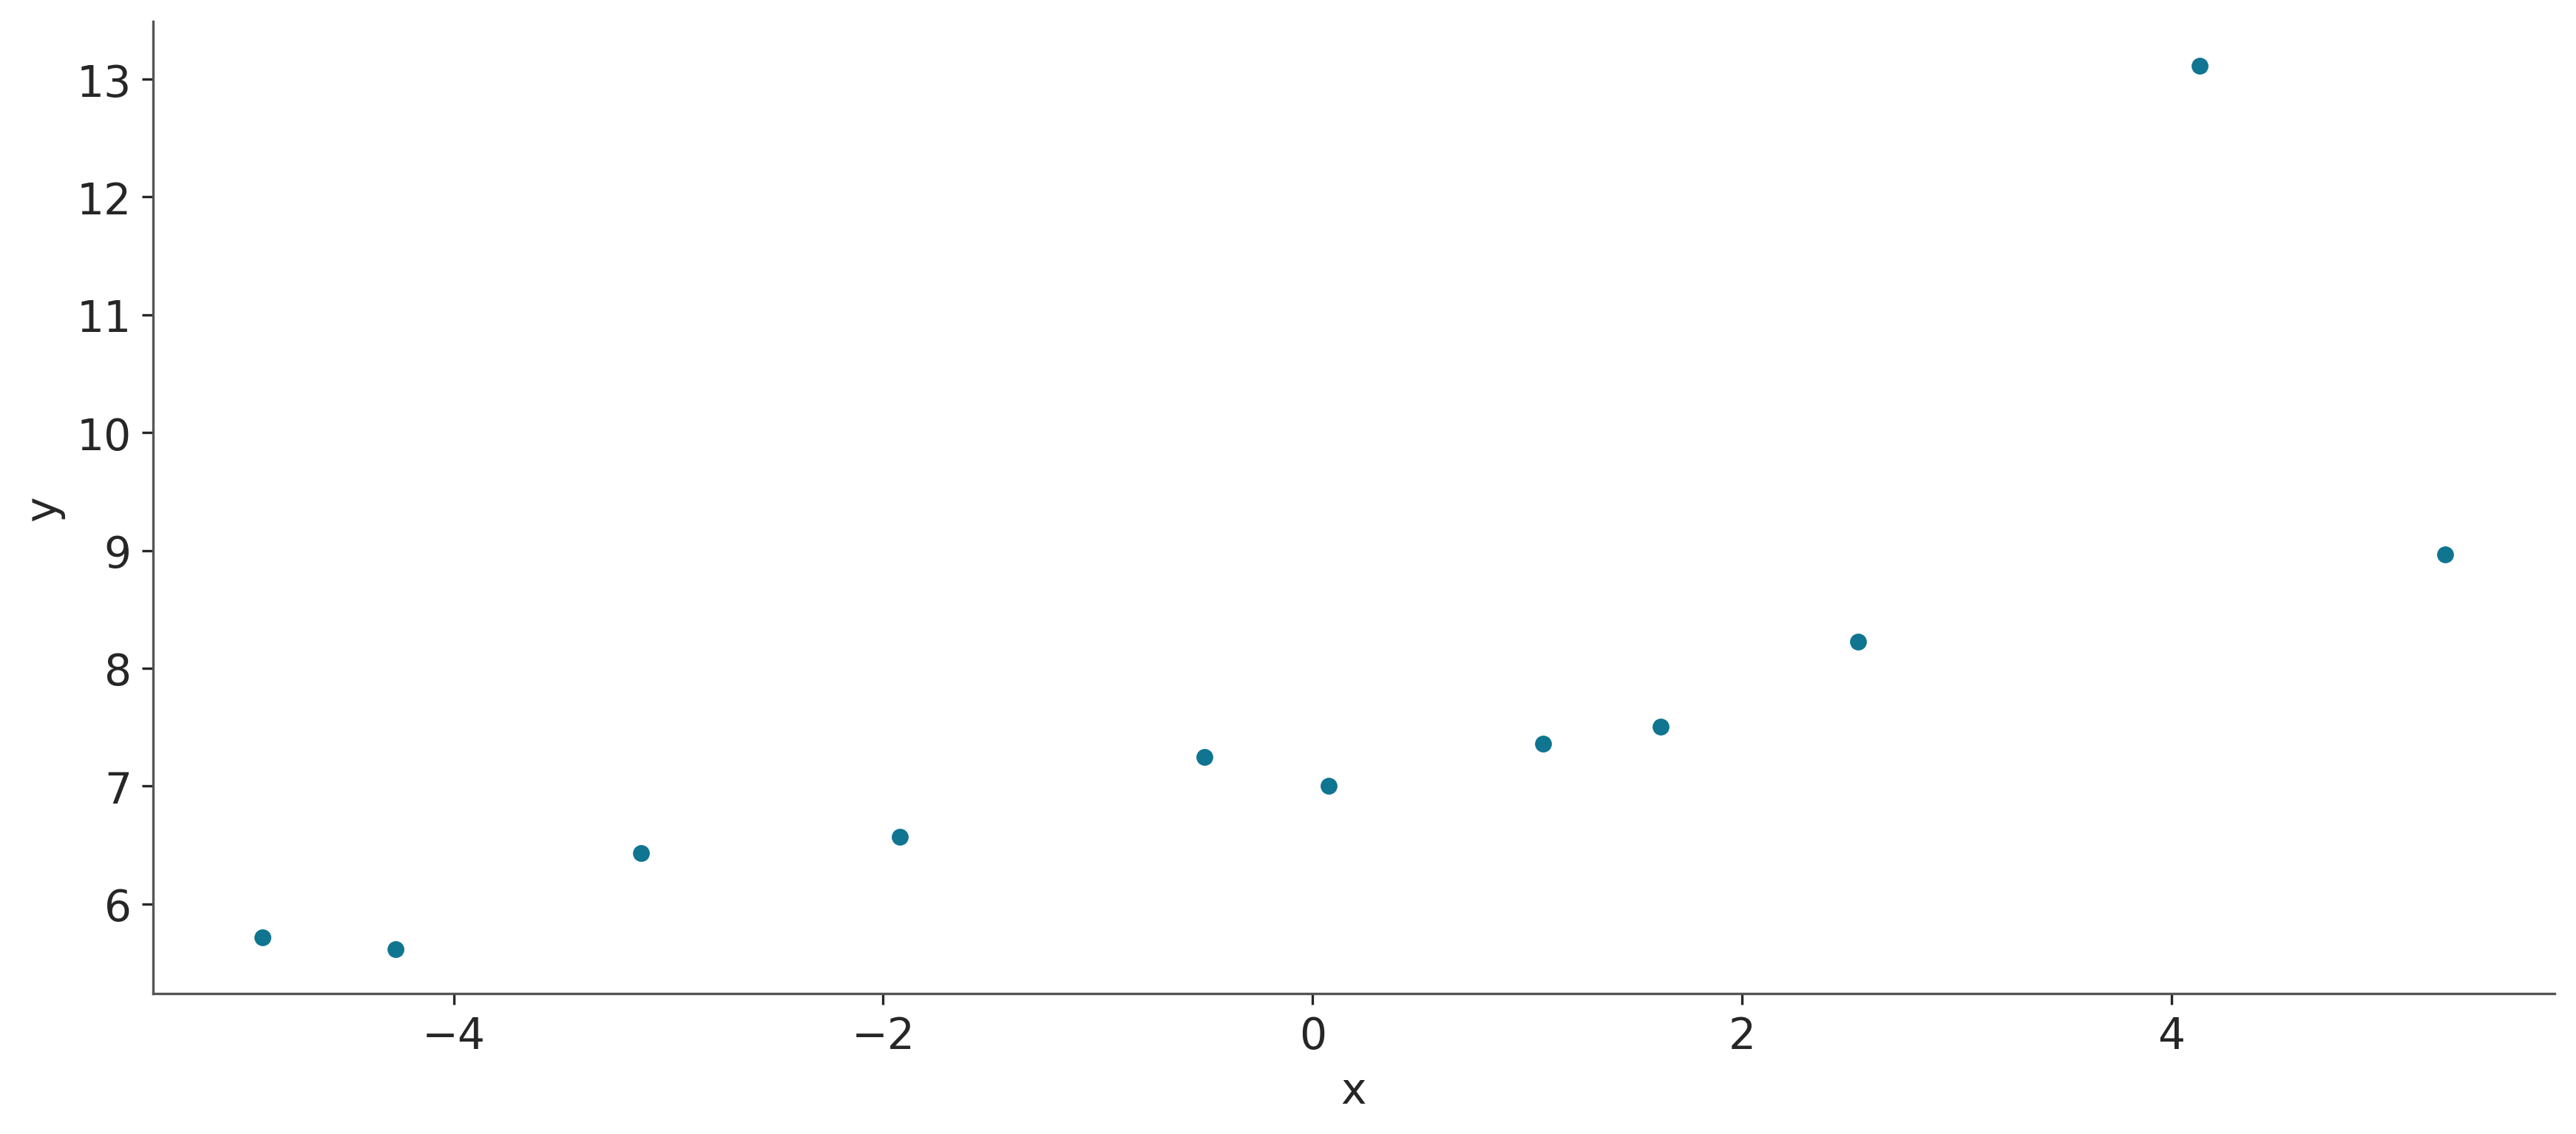

In [14]:
ans = pd.read_csv('data/anscombe_3.csv')
ans.plot("x", "y", kind="scatter");

In [15]:
with pm.Model() as t_model:
    α = pm.Normal('α', mu=ans.y.mean(), sigma=1)
    β = pm.Normal('β', mu=0, sigma=1)
    σ = pm.HalfNormal('σ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    μ = pm.Deterministic('μ', α + β * ans.x)
    _ = pm.StudentT('y_pred', mu=μ, sigma=σ, nu=ν, observed=ans.y)
    idata_t = pm.sample(2000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β, σ, ν_]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
        <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'ν_'}>, <Axes: title={'center': 'ν'}>,
        <Axes: >]], dtype=object)

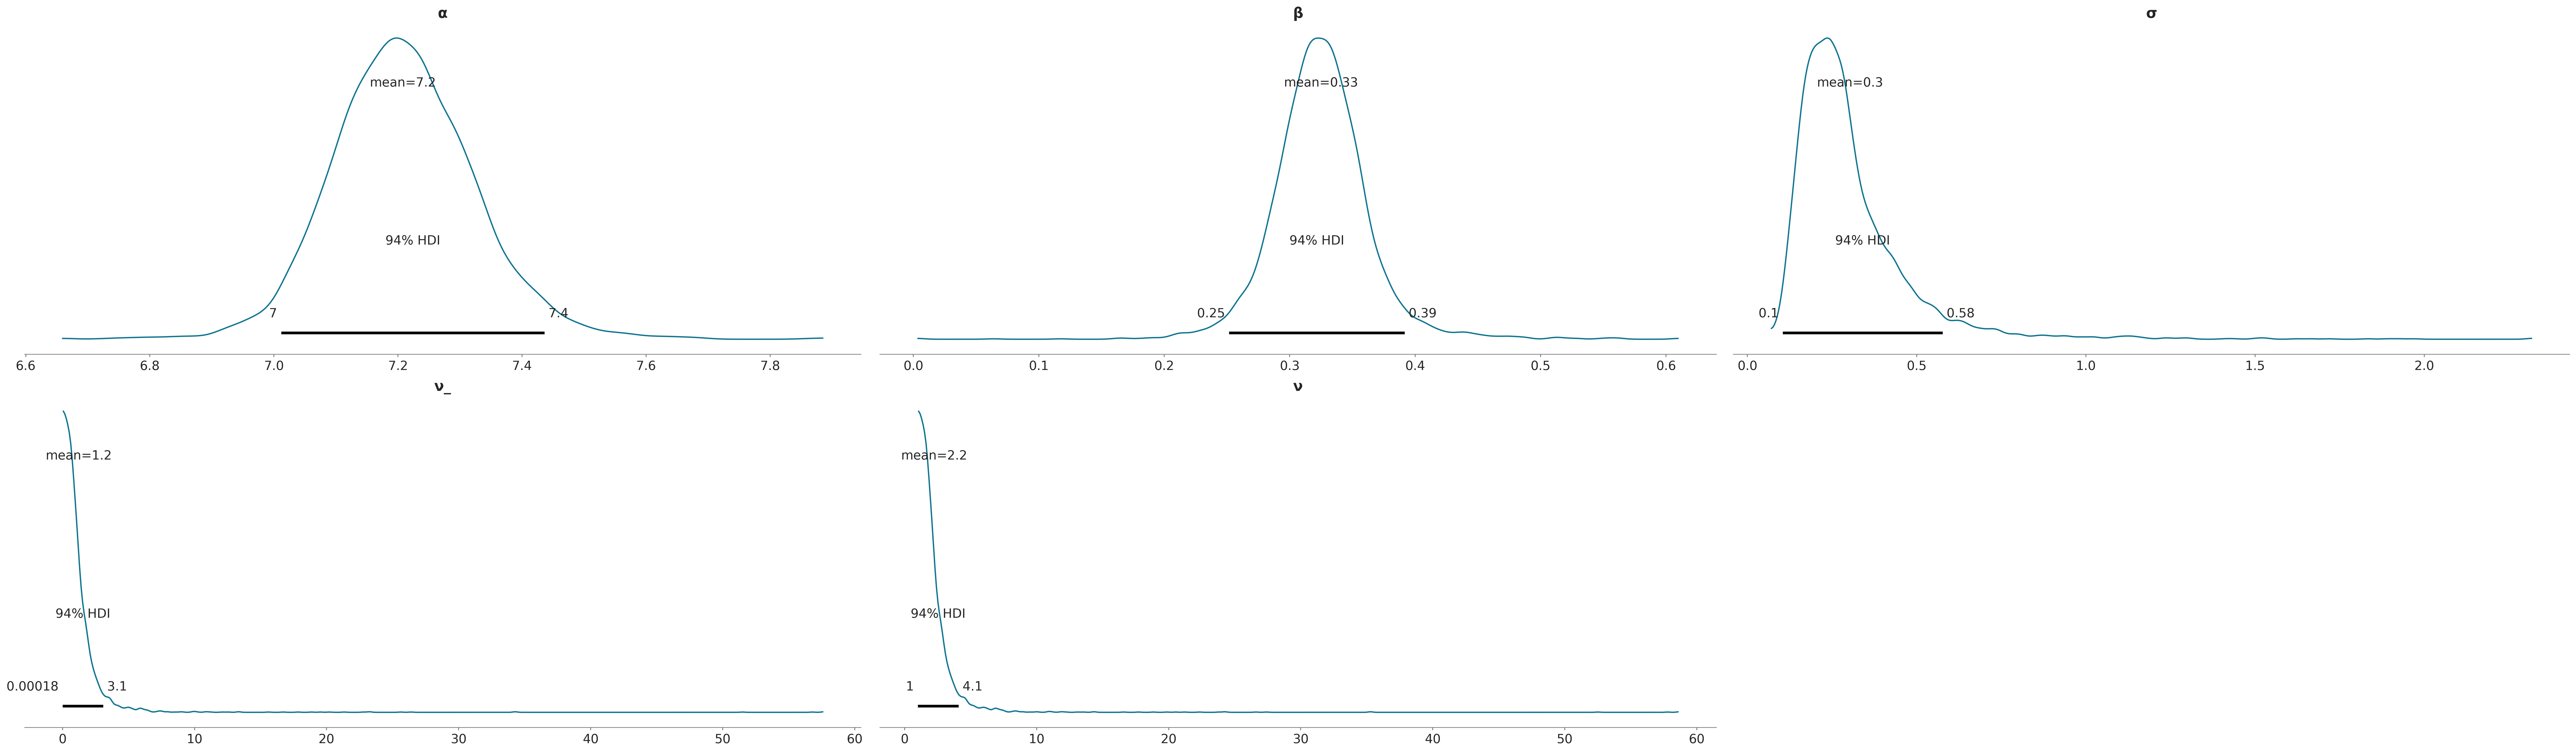

In [16]:
az.plot_posterior(idata_t,var_names=['~μ'])

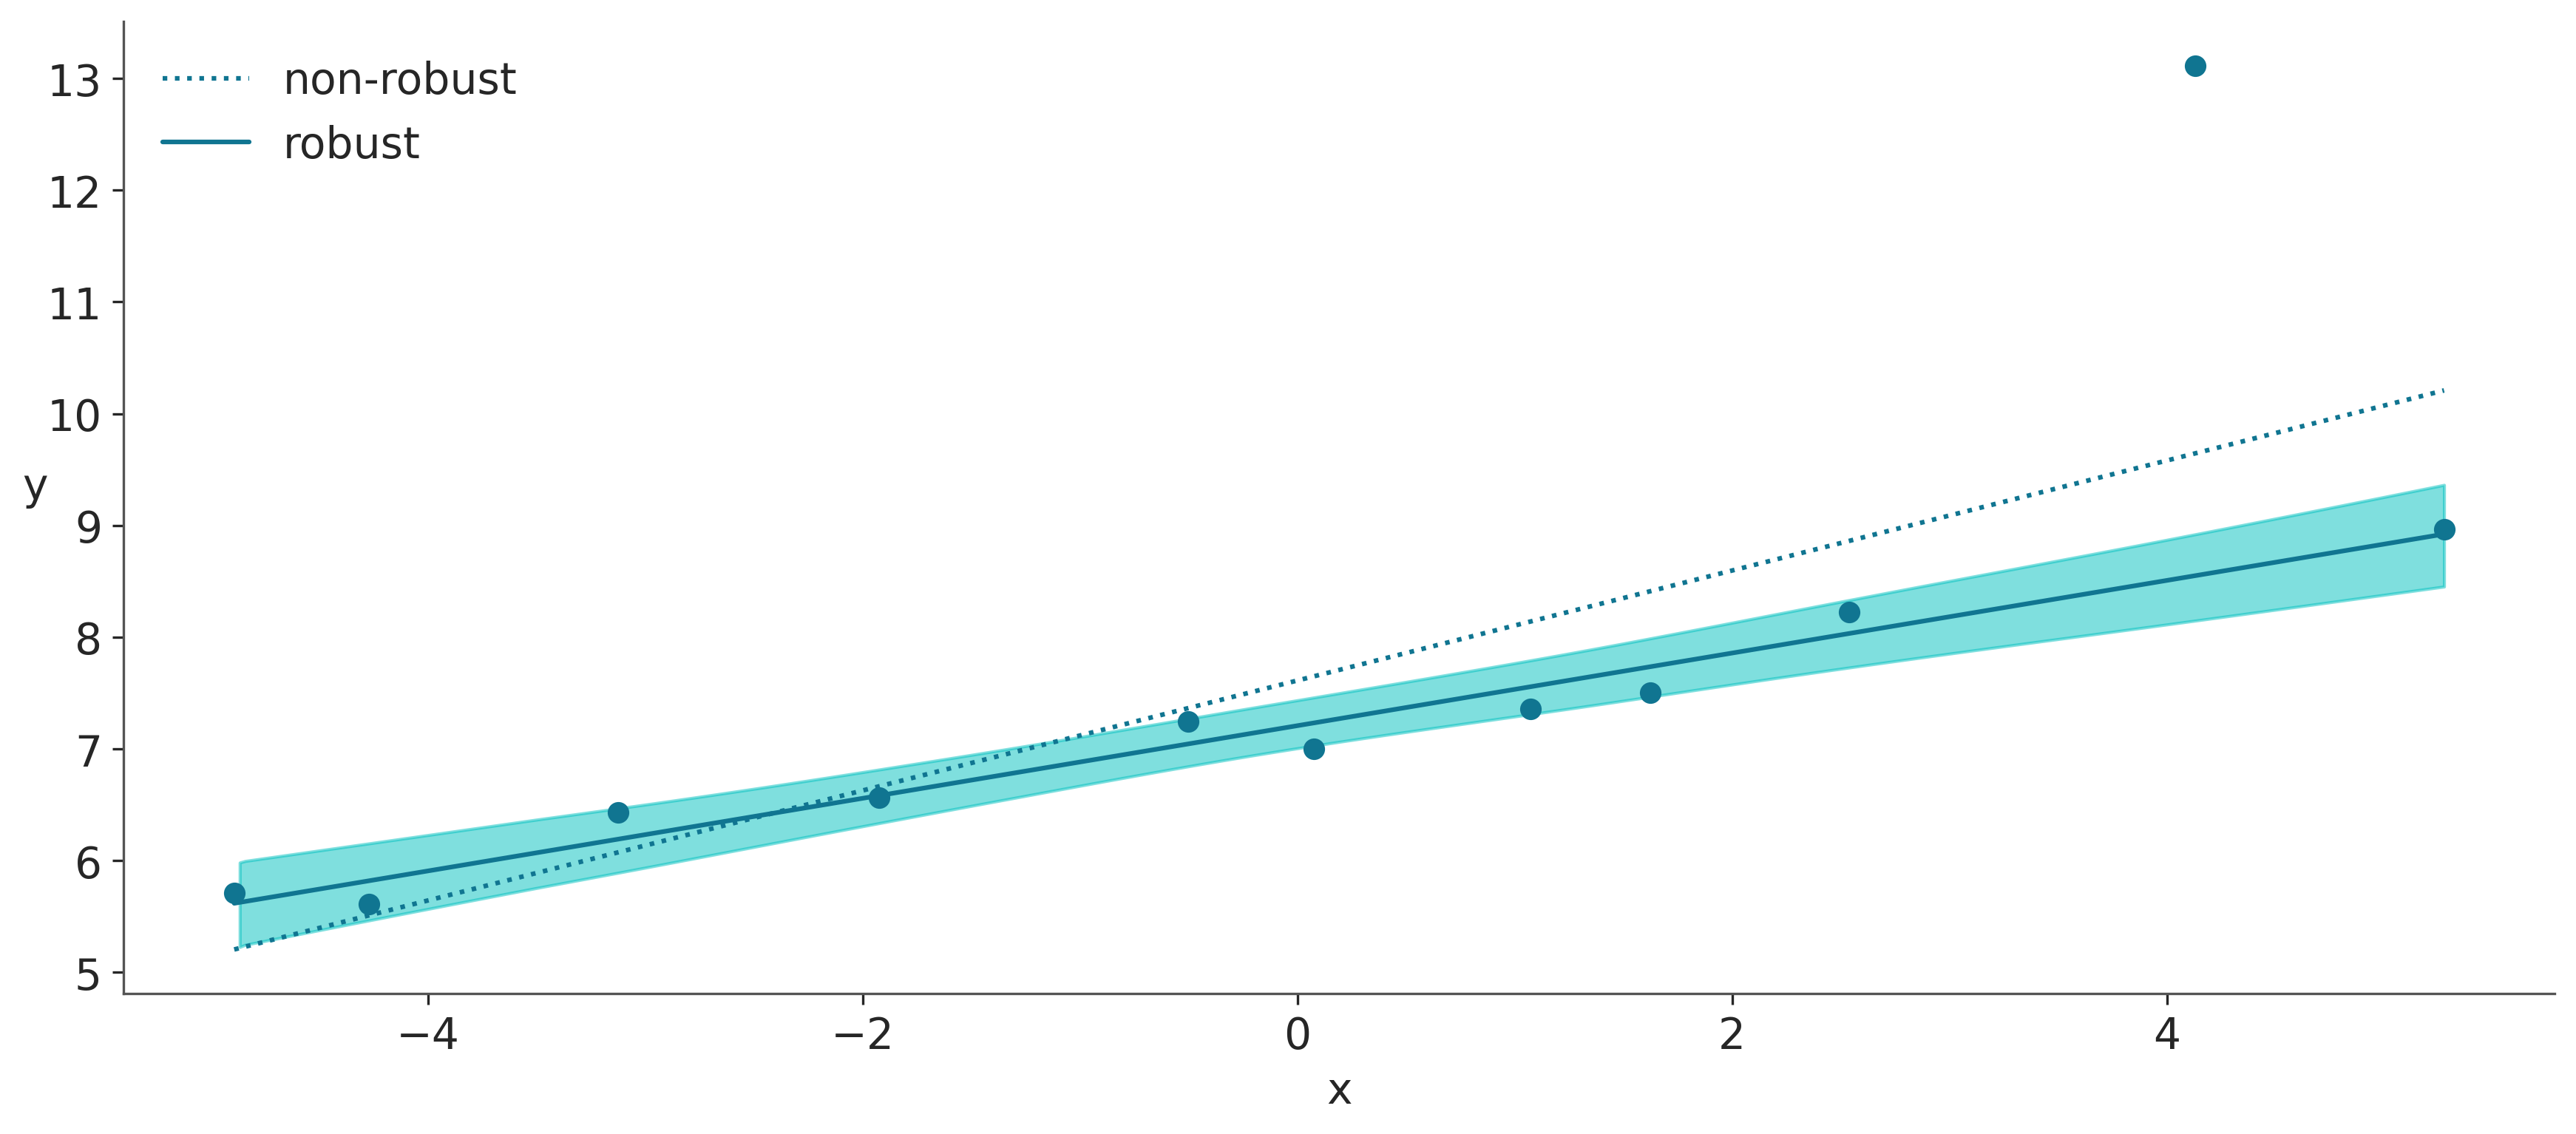

In [17]:
beta_c, alpha_c, *_ = linregress(ans.x, ans.y)

_, ax = plt.subplots()
ax.plot(ans.x, (alpha_c + beta_c * ans.x), 'C0:', label='non-robust')
ax.plot(ans.x, ans.y, 'C0o')
alpha_m = idata_t.posterior['α'].mean(("chain", "draw"))
beta_m = idata_t.posterior['β'].mean(("chain", "draw"))

x_plot = xr.DataArray(np.linspace(ans.x.min(), ans.x.max(), 50), dims="plot_id")
ax.plot(x_plot, alpha_m + beta_m * x_plot, c='C0', label="robust")
az.plot_hdi(ans.x, az.hdi(idata_t.posterior['μ'])['μ'].T, ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0)
ax.legend(loc=2);

## Logistic Regression
- Generalization of the linear model when the dependent variable is binary
- Inverse link function $$sigmoid(z) = \frac{1}{1 + e^{-z}}$$
- Linear model formulation $$\theta = sigmoid(\alpha + \beta X)$$ $$Y \sim Bern(\theta)$$

In [18]:
iris = pd.read_csv('data/iris.csv')
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [19]:
df = iris.query("species == ('setosa', 'versicolor')") # Centering the data helps with sampling
y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [20]:
with pm.Model() as lr_model:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=5)
    
    μ = α + β * x_c   
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) # inverse link function
    bd = pm.Deterministic('bd', -α/β) # decision boundary
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)

    idata_lr = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [21]:
az.summary(idata_lr, var_names='~θ')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.262  0.308  -0.376    0.785      0.007    0.006    1752.0    1246.0   
β   5.206  1.017   3.293    7.138      0.027    0.020    1517.0    1115.0   
bd -0.049  0.058  -0.151    0.072      0.001    0.001    1792.0    1272.0   

    r_hat  
α     1.0  
β     1.0  
bd    1.0

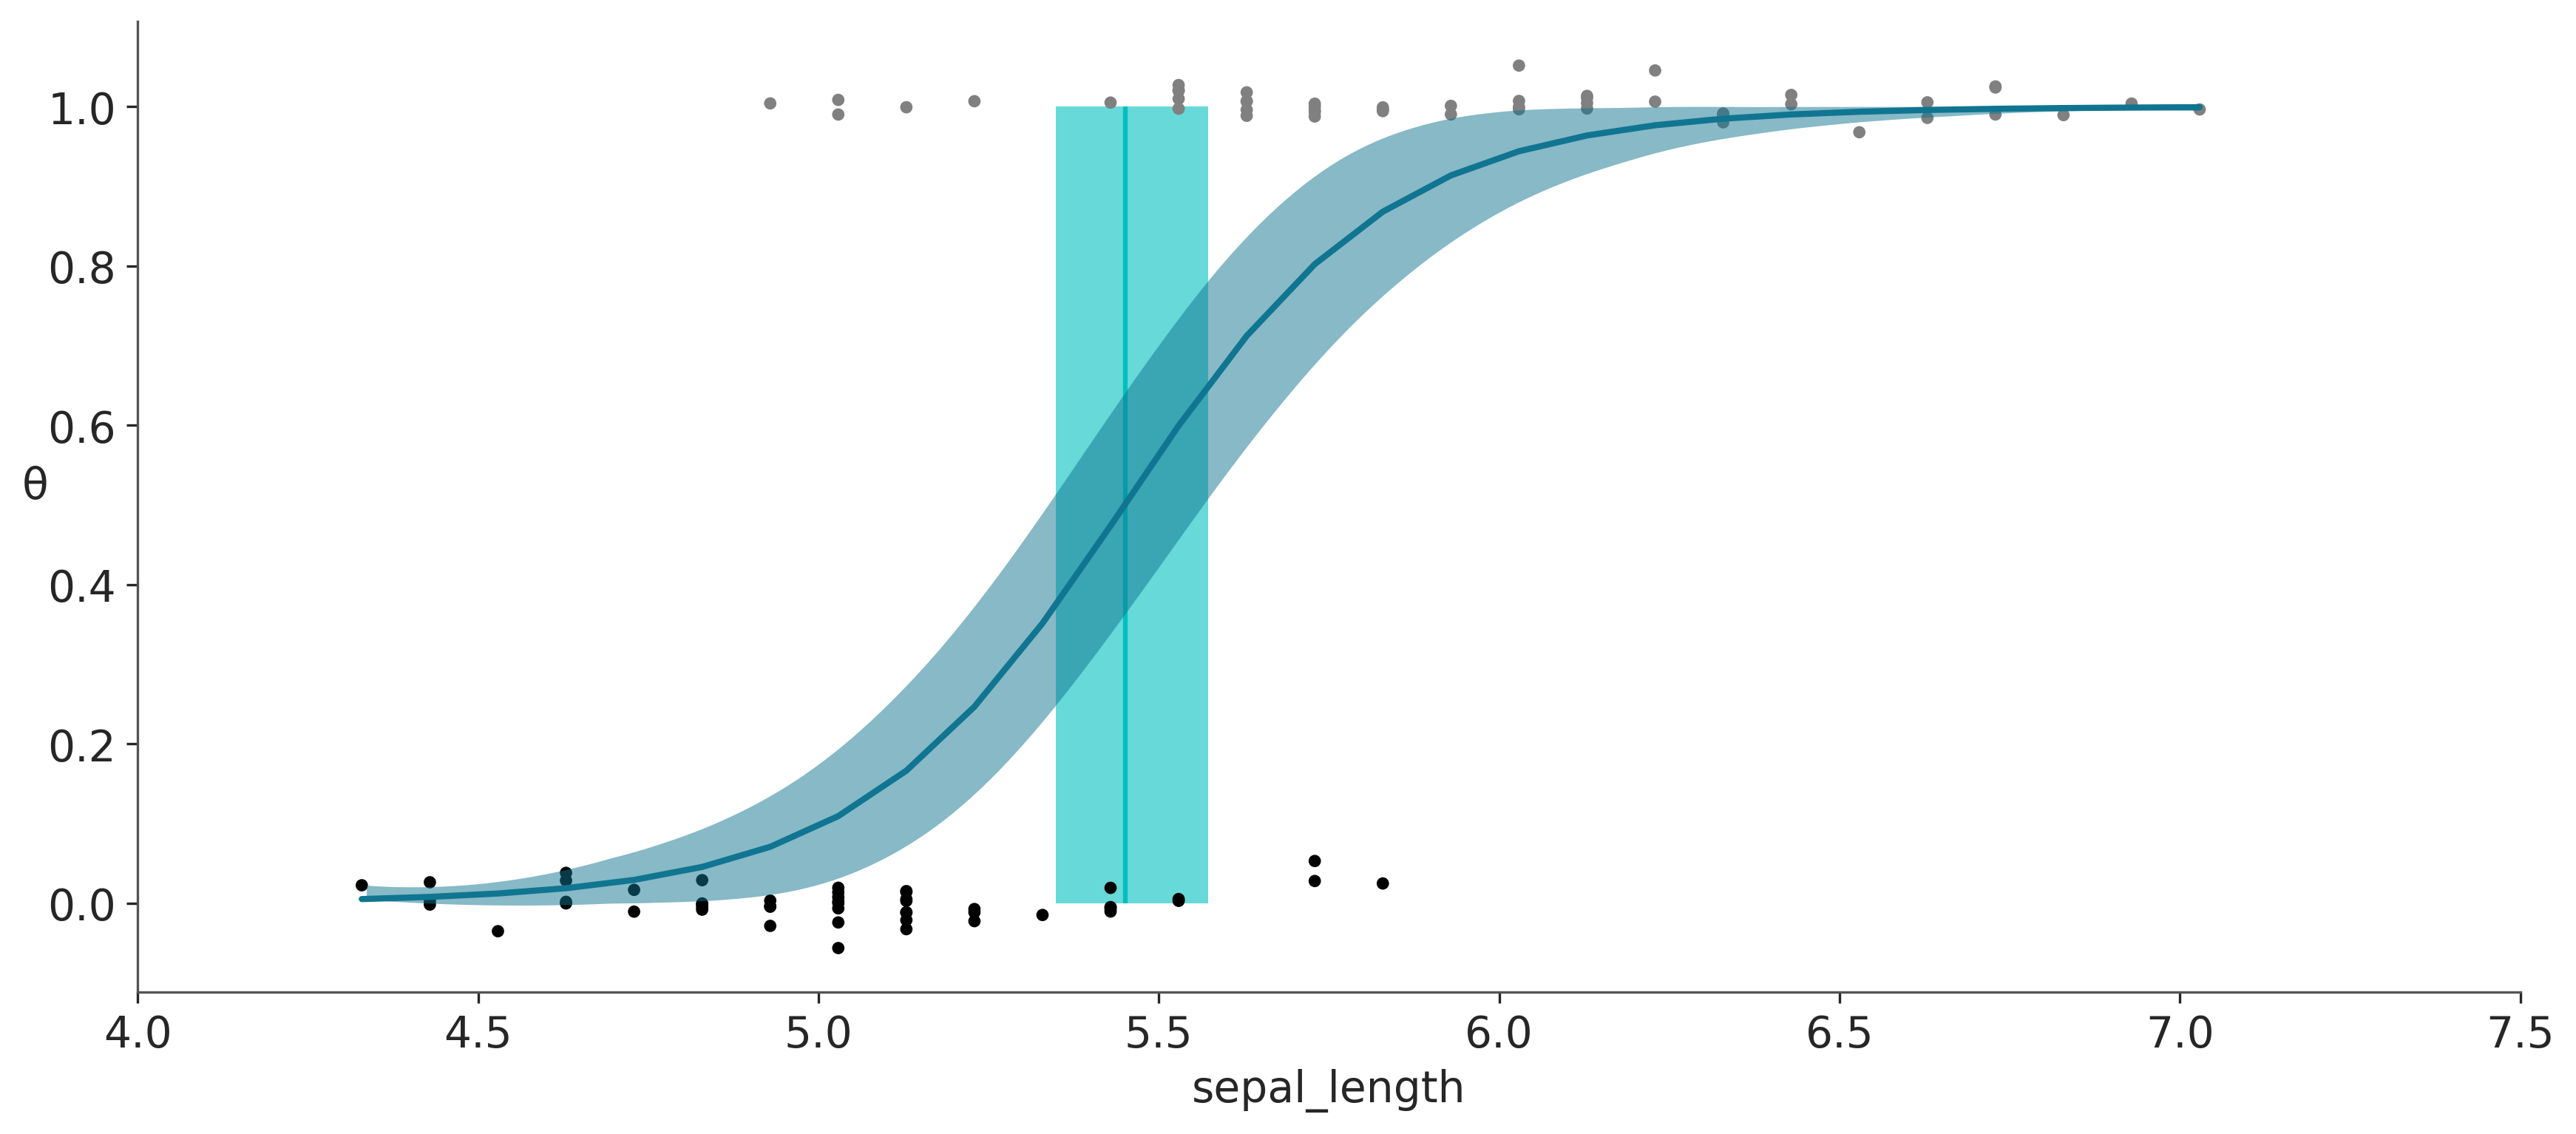

In [22]:
posterior = idata_lr.posterior
theta = posterior["θ"].mean(("chain", "draw"))
idx = np.argsort(x_c)

_, ax = plt.subplots()

ax.plot(x_c[idx], theta[idx], color='C0', lw=2)
ax.vlines(posterior['bd'].mean(("chain", "draw")), 0, 1, color='C1', zorder=0)
bd_hdi = az.hdi(posterior['bd']) # 94% hdi
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color='C1', alpha=0.6, lw=0)
ax.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'{0.5*x}' for x in y_0])
az.plot_hdi(x_c, posterior['θ'], color='C0', ax=ax, fill_kwargs={"lw": 0})
ax.set_xlabel(x_n)
ax.set_ylabel('θ', rotation=0)
locs, _ = plt.xticks()
ax.set_xticks(locs, np.round(locs + x_0.mean(), 1));

- Logistic Regression coefficients
  - The inverse of the logistic function is the logit, given by $logit(z) = log(\frac{z}{1-z})$
  - Applying logit on both sides of $\theta = sigmoid(\alpha + \beta X)$ yields $$log(\frac{\theta}{1-\theta}) = \alpha + \beta X$$
  - $\theta$ represents $p(y=1)$, so $$log(\frac{p(y=1)}{p(y=0)}) = \alpha + \beta X$$
  - Coefficient $\beta$ encodes the increase in units of log-odds per unit increase of $x$

## Variable Variance
- Using linear model to model the mean of the distribution, leaving aside variance
- If we consider that constant variance doesnt make sense, model it as a function of the inputs

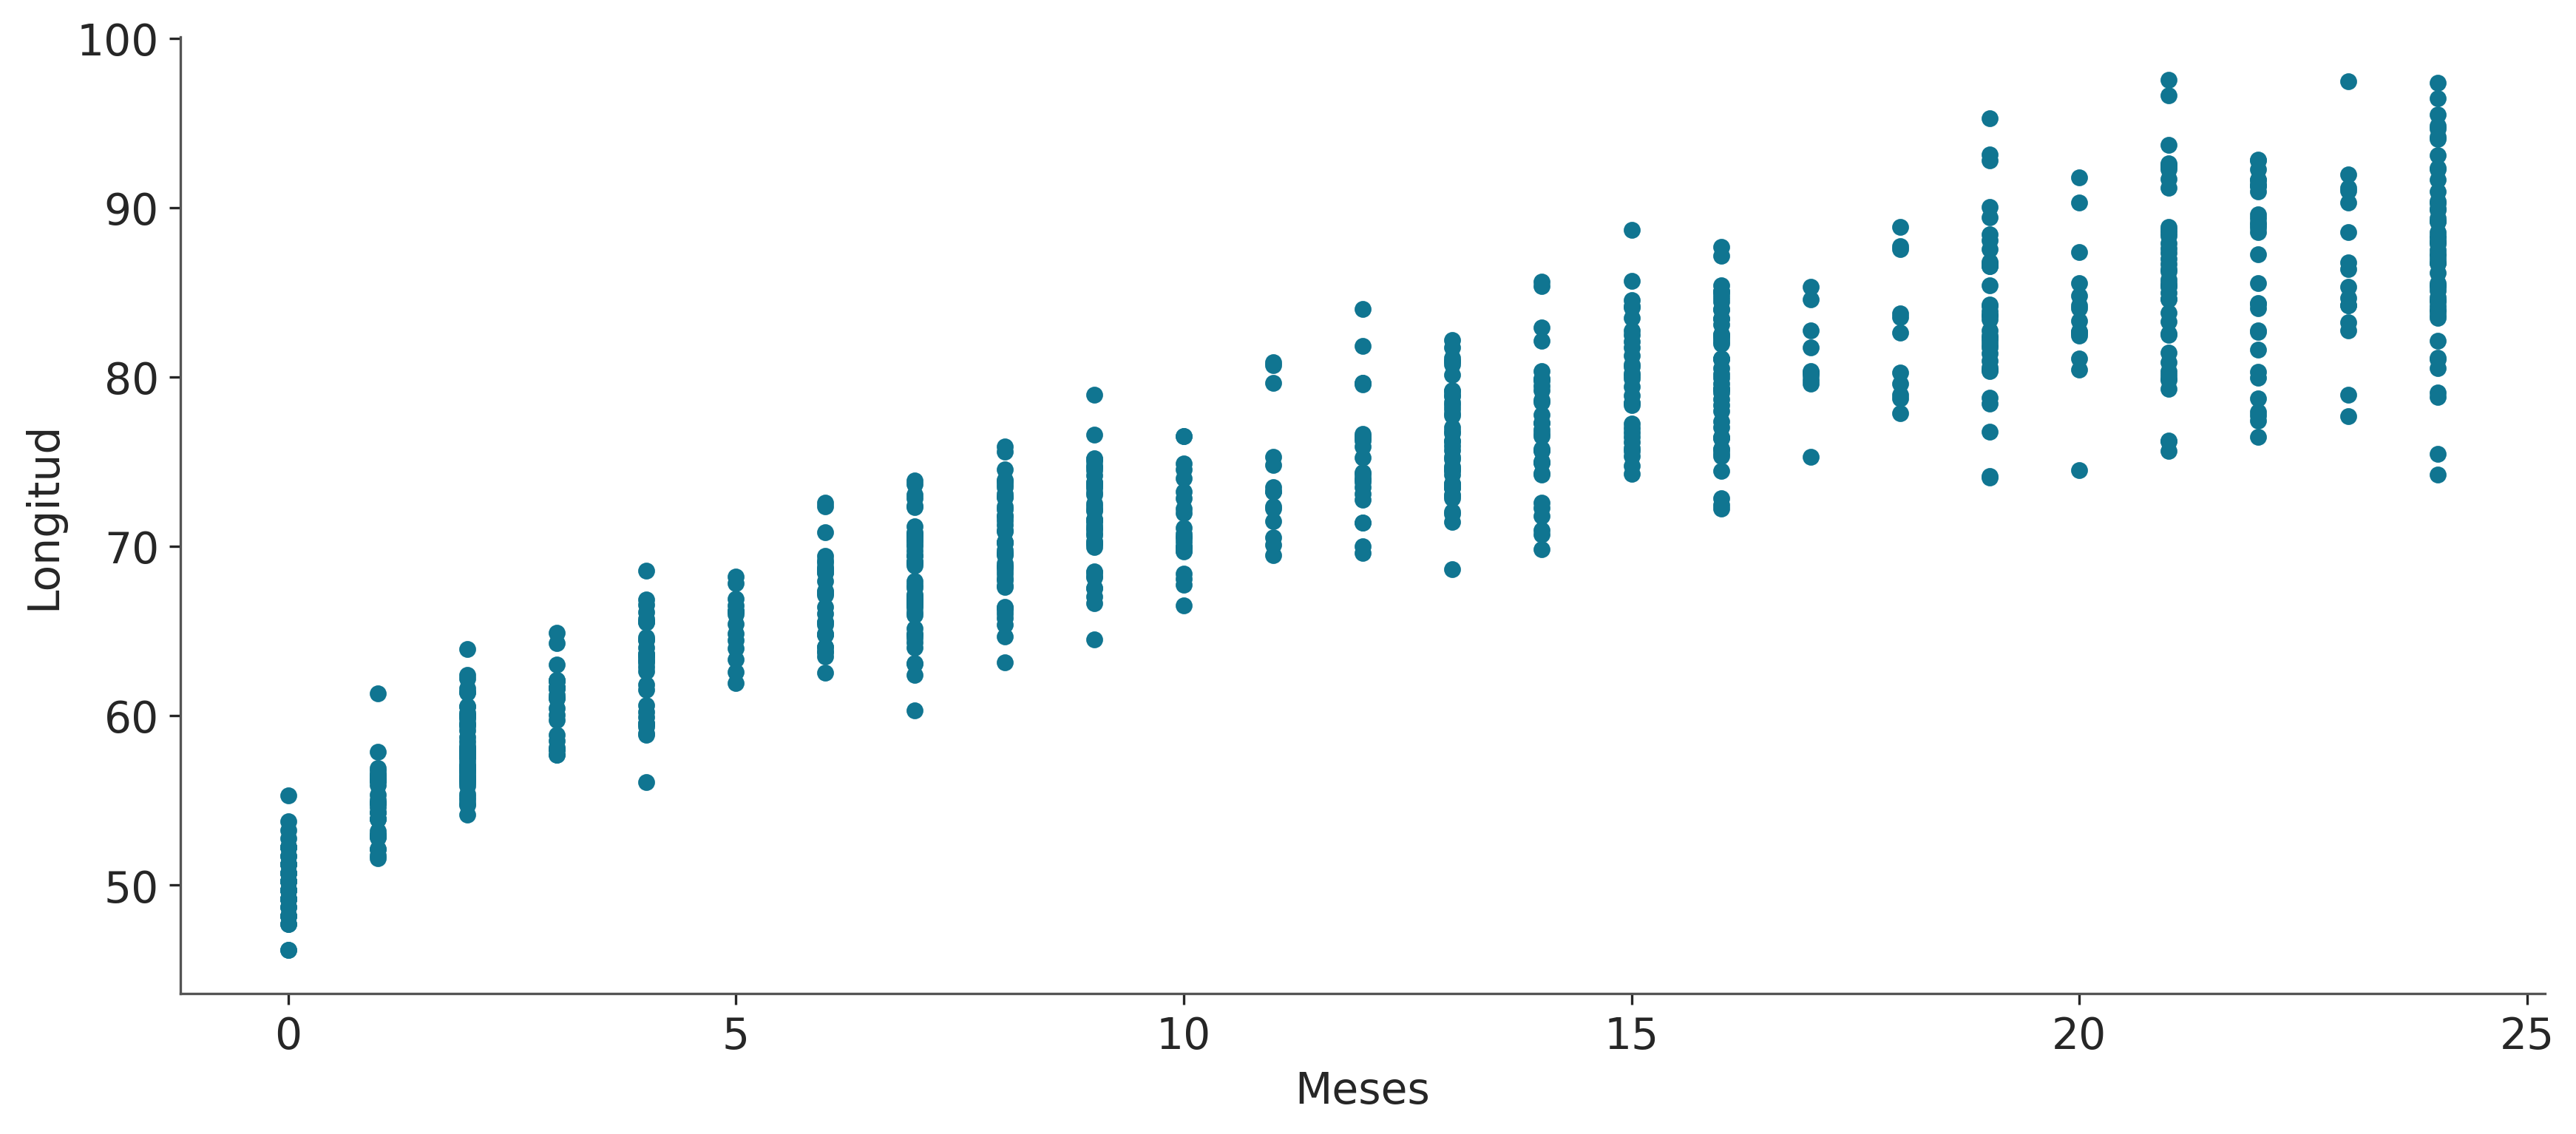

In [23]:
data = pd.read_csv('data/babies.csv')
data.plot.scatter('Meses', 'Longitud'); # Longitud is height

In [24]:
with pm.Model() as model_vv:
    x_shared = pm.MutableData("x_shared", data.Meses.values.astype(float)) # change the values of x without needing to resample the model
    α = pm.Normal('α', sigma=10)
    β = pm.Normal('β', sigma=10)
    γ = pm.HalfNormal('γ', sigma=10)
    δ = pm.HalfNormal('δ', sigma=10)


    μ = pm.Deterministic('μ', α + β * x_shared**0.5) # trick to fit the function (non linearity)
    σ = pm.Deterministic('σ', γ + δ * x_shared) # model sigma as a function of the input
    
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=data.Longitud)
    
    idata_vv = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β, γ, δ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


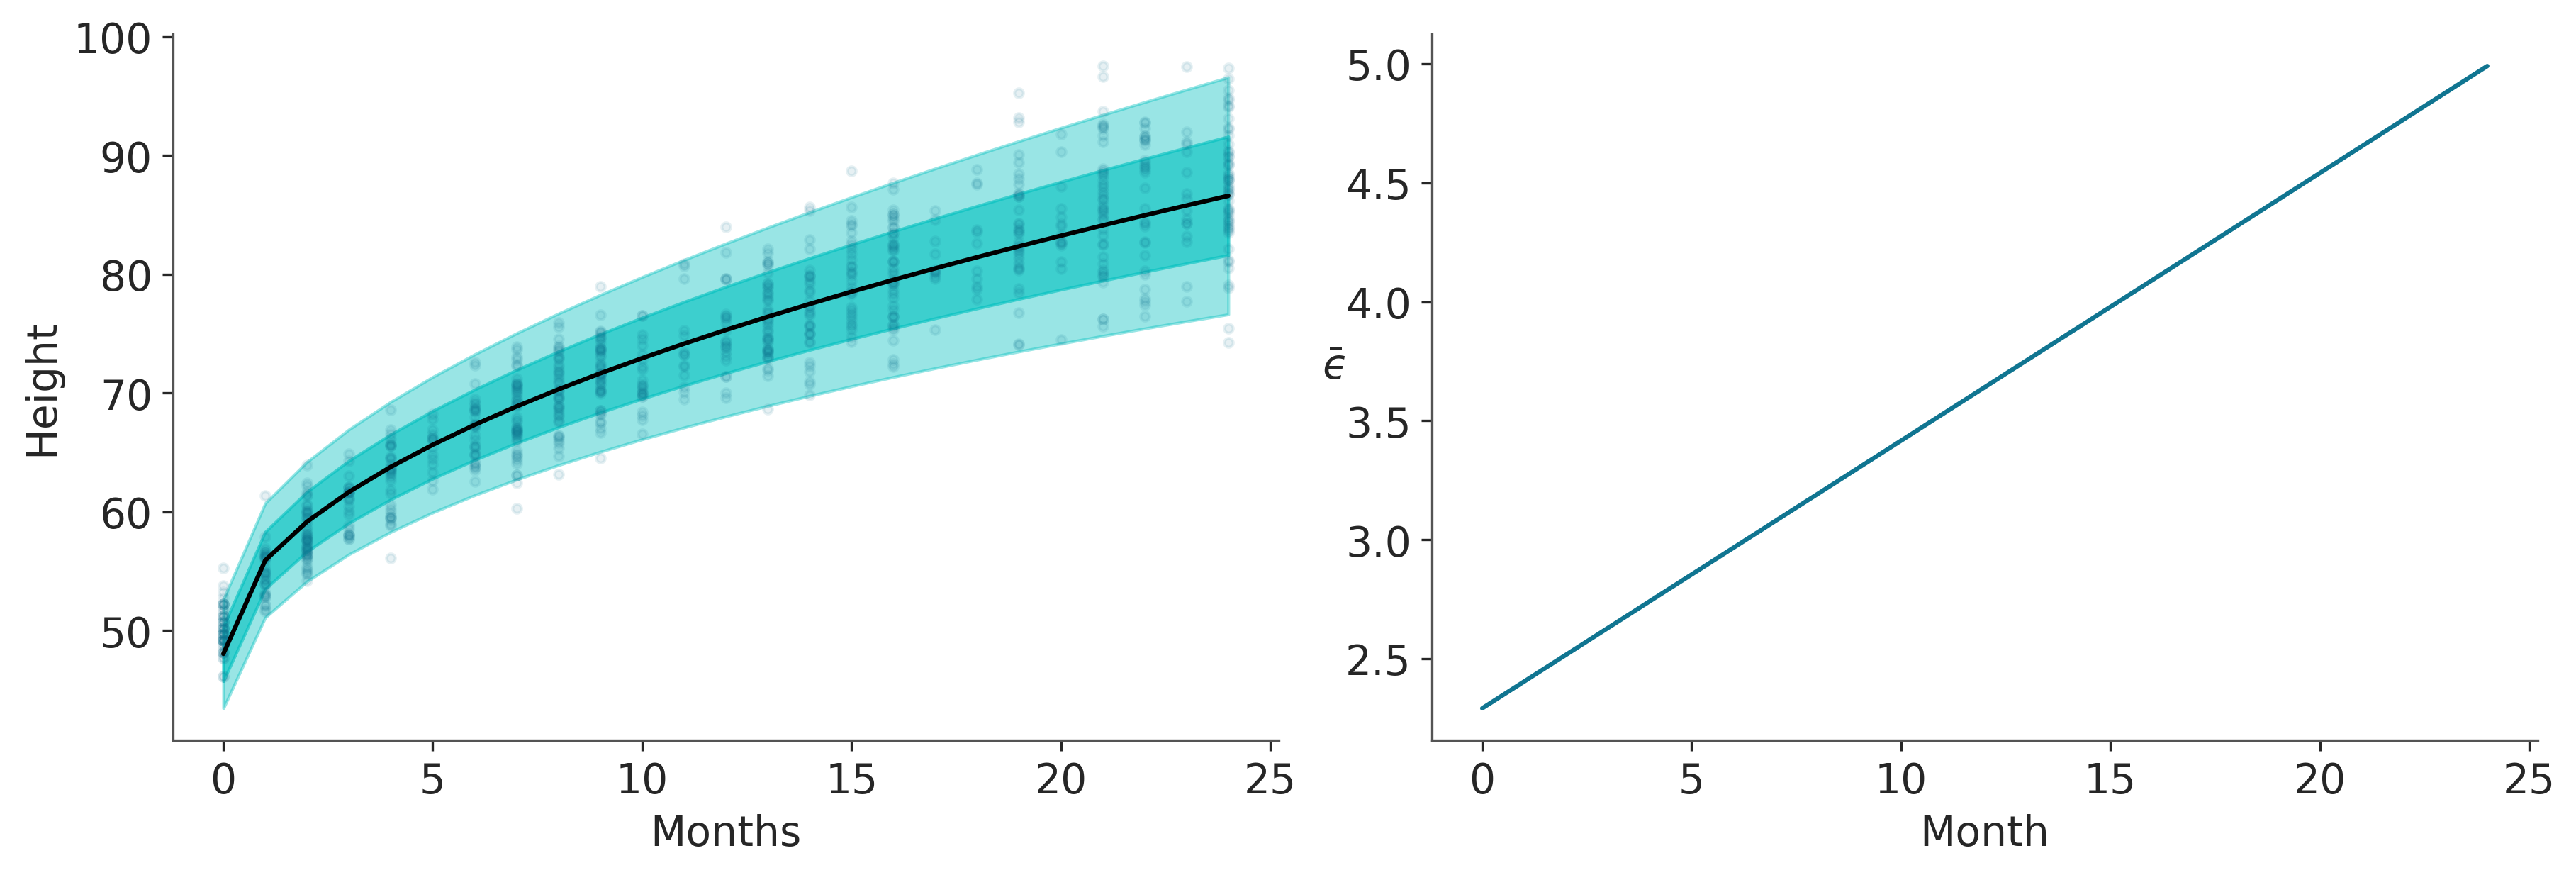

In [25]:
_, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(data.Meses, data.Longitud, 'C0.', alpha=0.1);

posterior = az.extract(idata_vv)

μ_m = posterior['μ'].mean("sample").values
σ_m = posterior['σ'].mean("sample").values

axes[0].plot(data.Meses, μ_m, c='k')
axes[0].fill_between(data.Meses, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color='C1')
axes[0].fill_between(data.Meses, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color='C1')

axes[0].set_xlabel('Months')
axes[0].set_ylabel('Height');


axes[1].plot(data.Meses, σ_m)
axes[1].set_xlabel('Month');
axes[1].set_ylabel(r'$\bar ϵ$', rotation=0);

- Easiest way to obtain predictions for unobserved values is to defined a shared variable

In [26]:
with model_vv:
    pm.set_data({"x_shared": [0.5]})
    ppc = pm.sample_posterior_predictive(idata_vv, random_seed=123)
    y_ppc = ppc.posterior_predictive['y_pred'].stack(sample=("chain", "draw"))

Sampling: [y_pred]


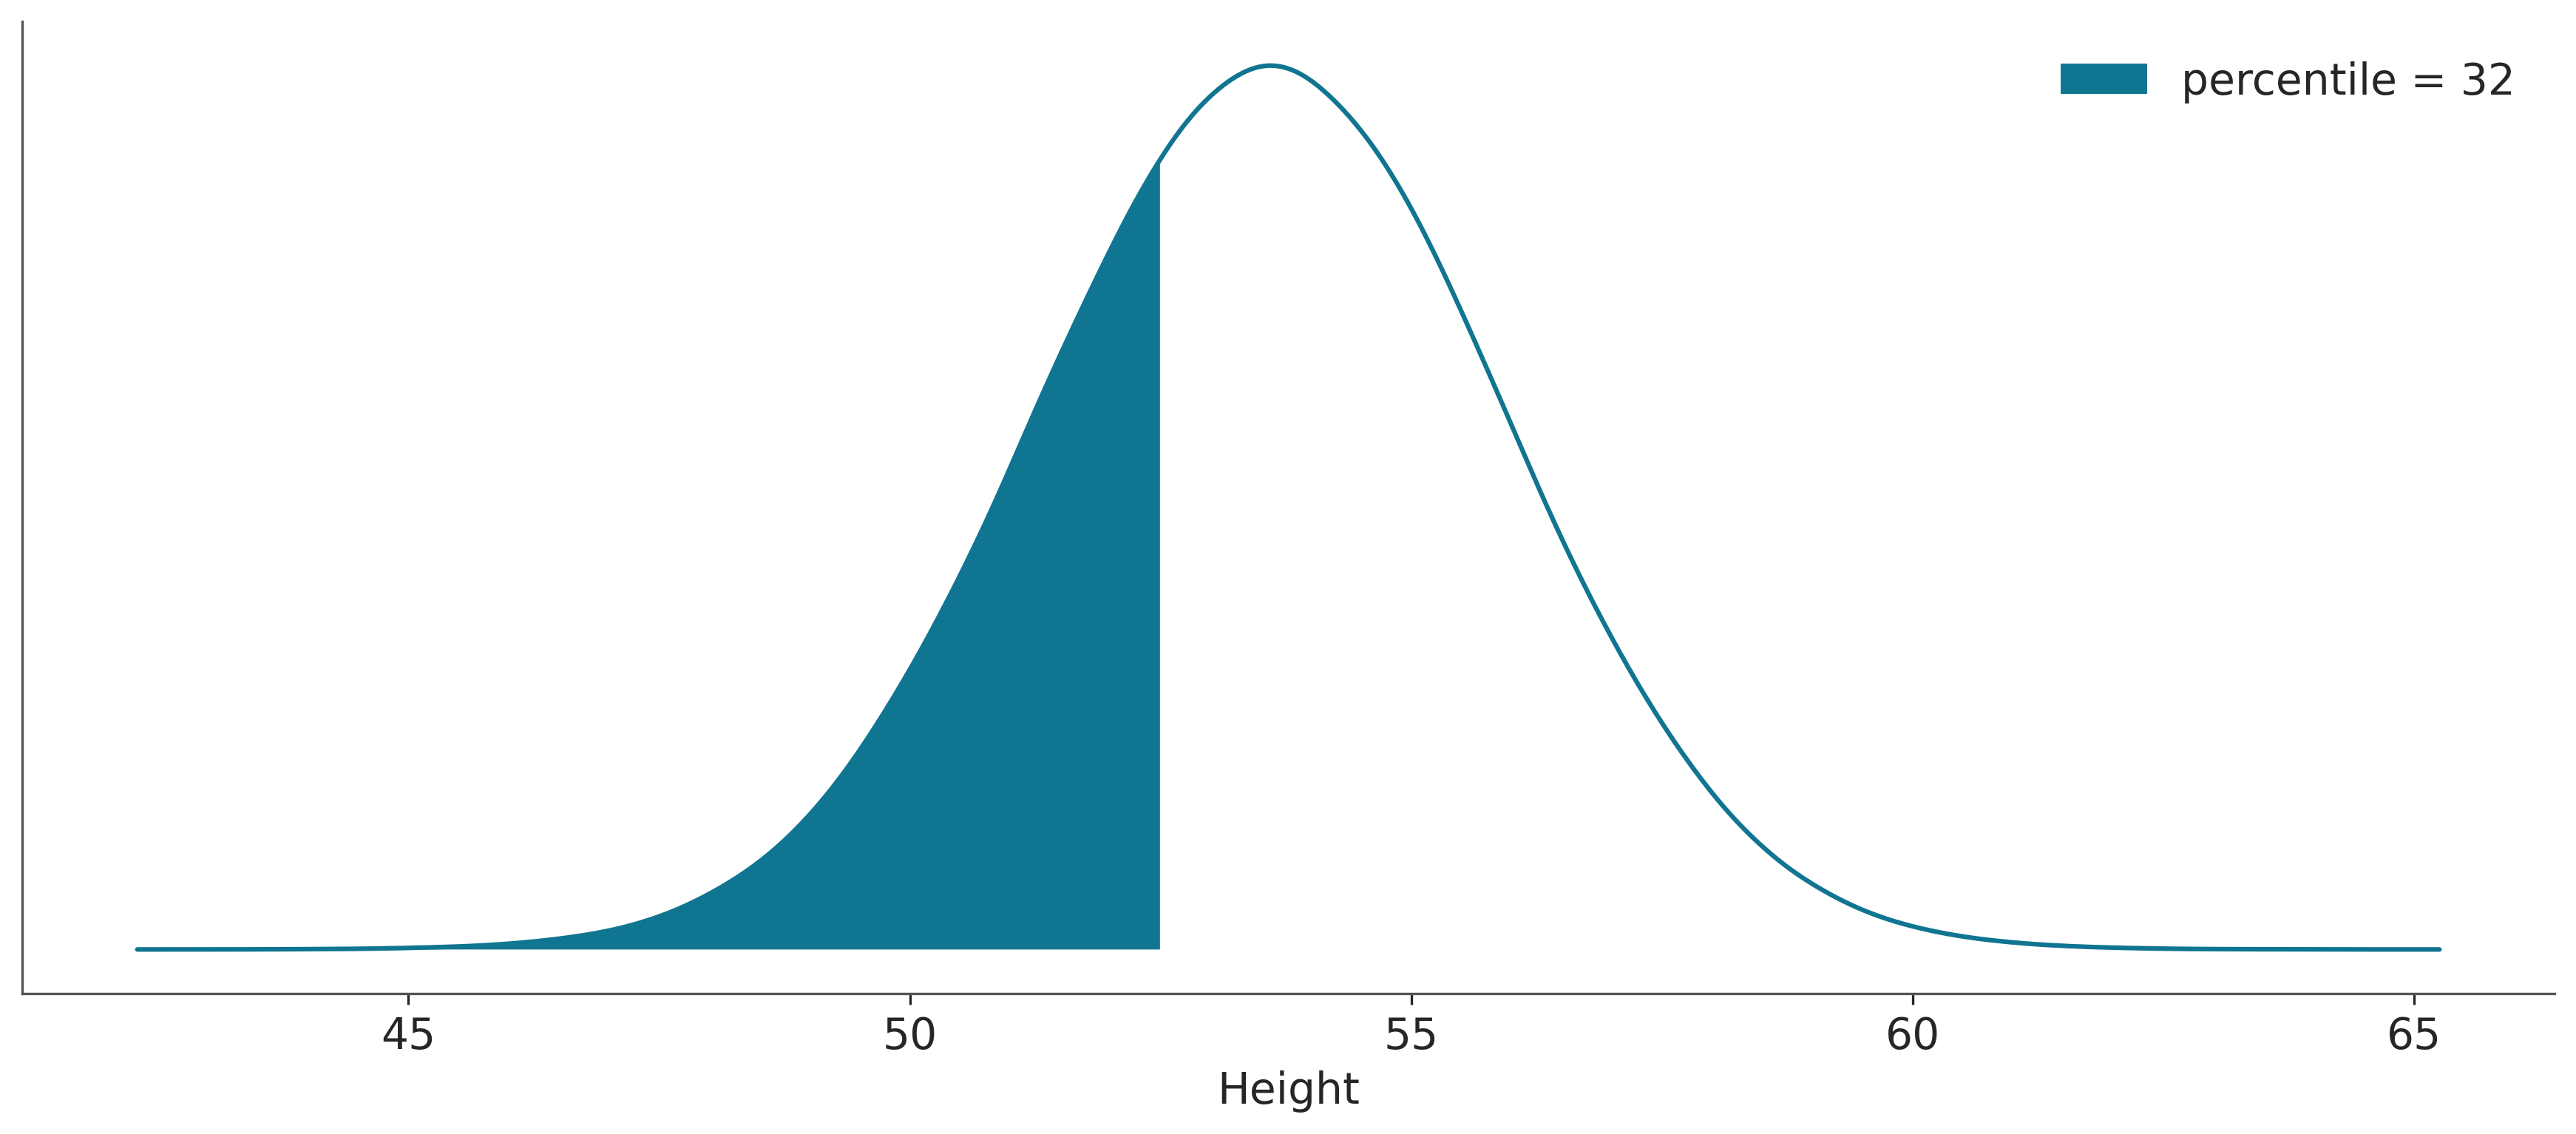

In [27]:
ref = 52.5
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc <= ref).mean() * 100)
plt.fill_between(grid[grid < ref], pdf[grid < ref], label='percentile = {:2d}'.format(percentile))
plt.xlabel('Height')
plt.yticks([])
plt.legend();

## Quantile Regression
- Objective is to estimate a quantile, not a mean
- When the quantile to be estimated is the median, the motivation is usually the need for a robust regression
- Assymetric Laplace Distribution as likelihood
  - $\mu$: location
  - $\sigma$: scale
  - $q$: Assymetry. When $q$ is 0.5, the distribution is symmetric (Laplace distribution)

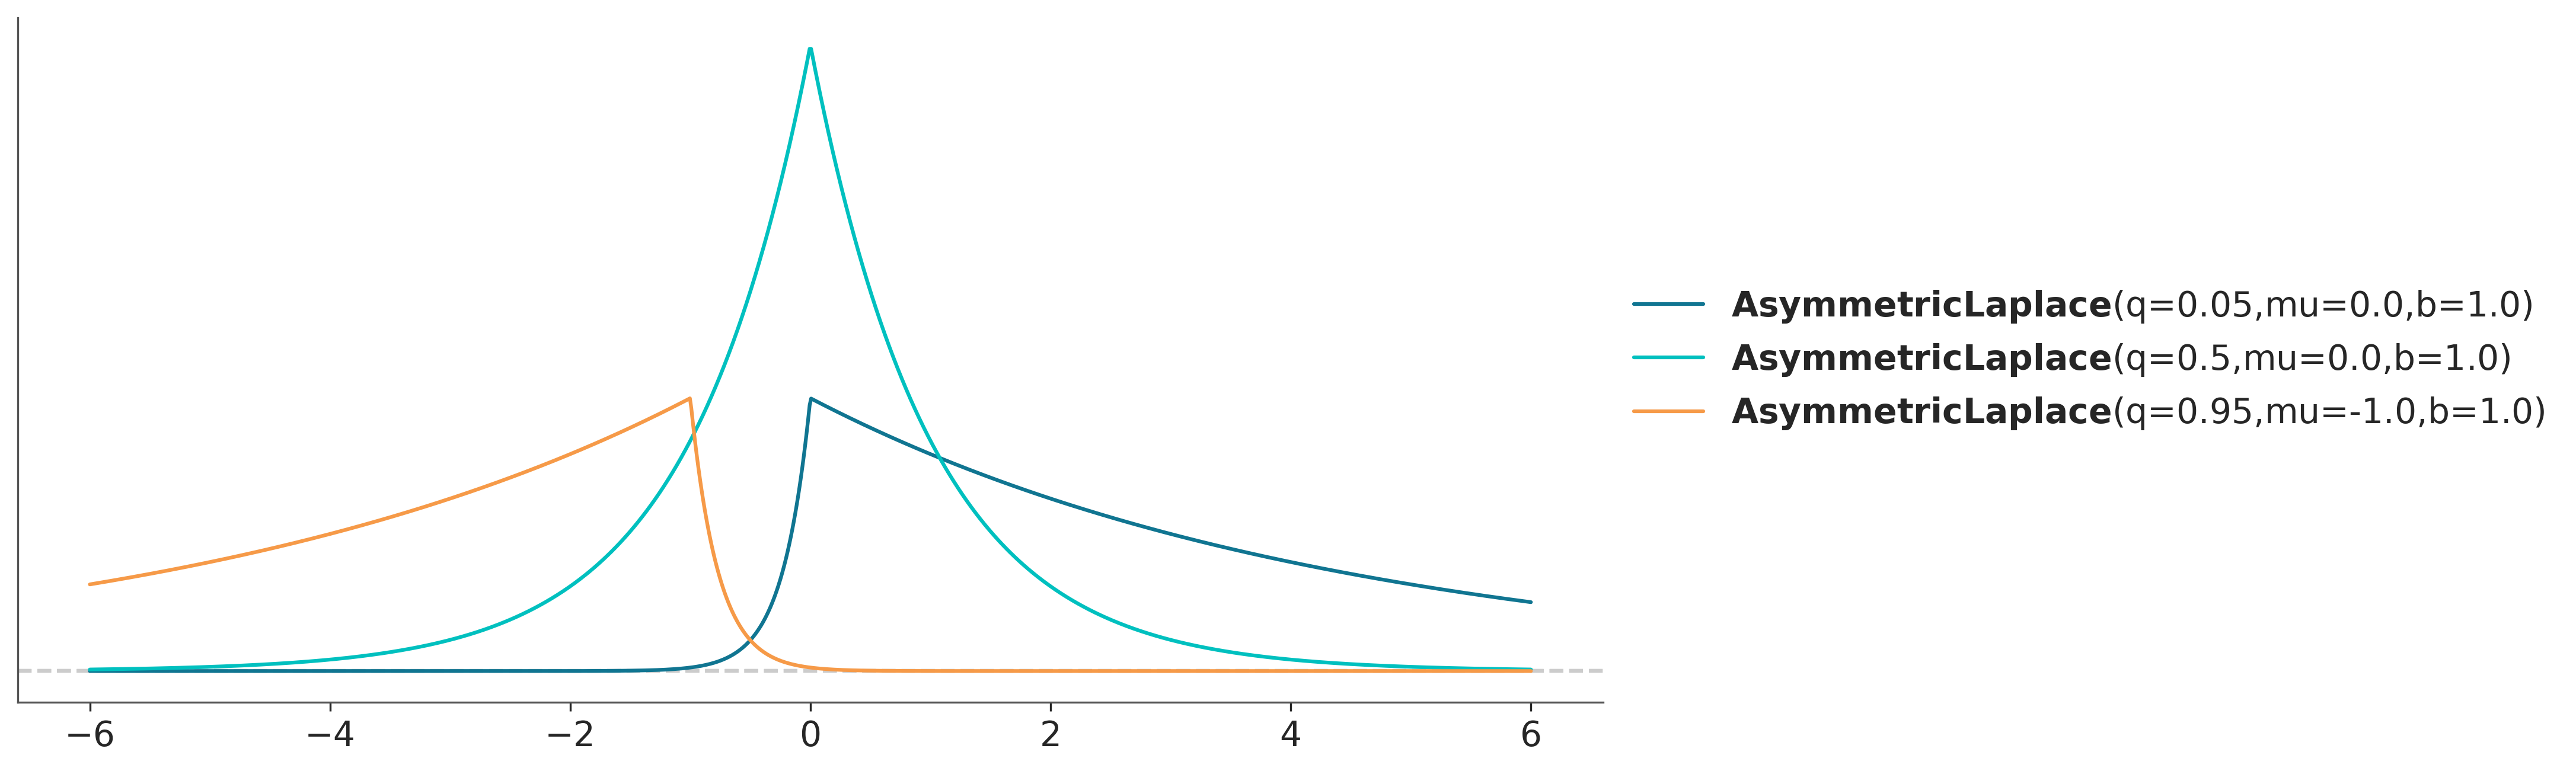

In [28]:
q = np.array([0.05, 0.5, 0.95])
for q_i, mu in zip(q, [0, 0, -1]):
    pz.AsymmetricLaplace(mu=mu, b=1, q=q_i).plot_pdf(support=(-6, 6))

In [29]:
y_con = np.stack([data.Longitud.values]* 3).T
x_con = np.stack([data.Meses.values]* 3).T # Stacking dataset 3 times, one for each quantile

In [30]:
with pm.Model() as model_q:
    α = pm.Normal('α', 50, 3, shape=3)
    β = pm.Normal('β', 0, 5, shape=3)
    σ = pm.HalfNormal('σ', 5)

    μ = pm.Deterministic('μ', α + β * x_con**0.5)
    
    y_pred = pm.AsymmetricLaplace('y_pred',  mu=μ, b=σ, q=q, observed=y_con)
    
    idata_q = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


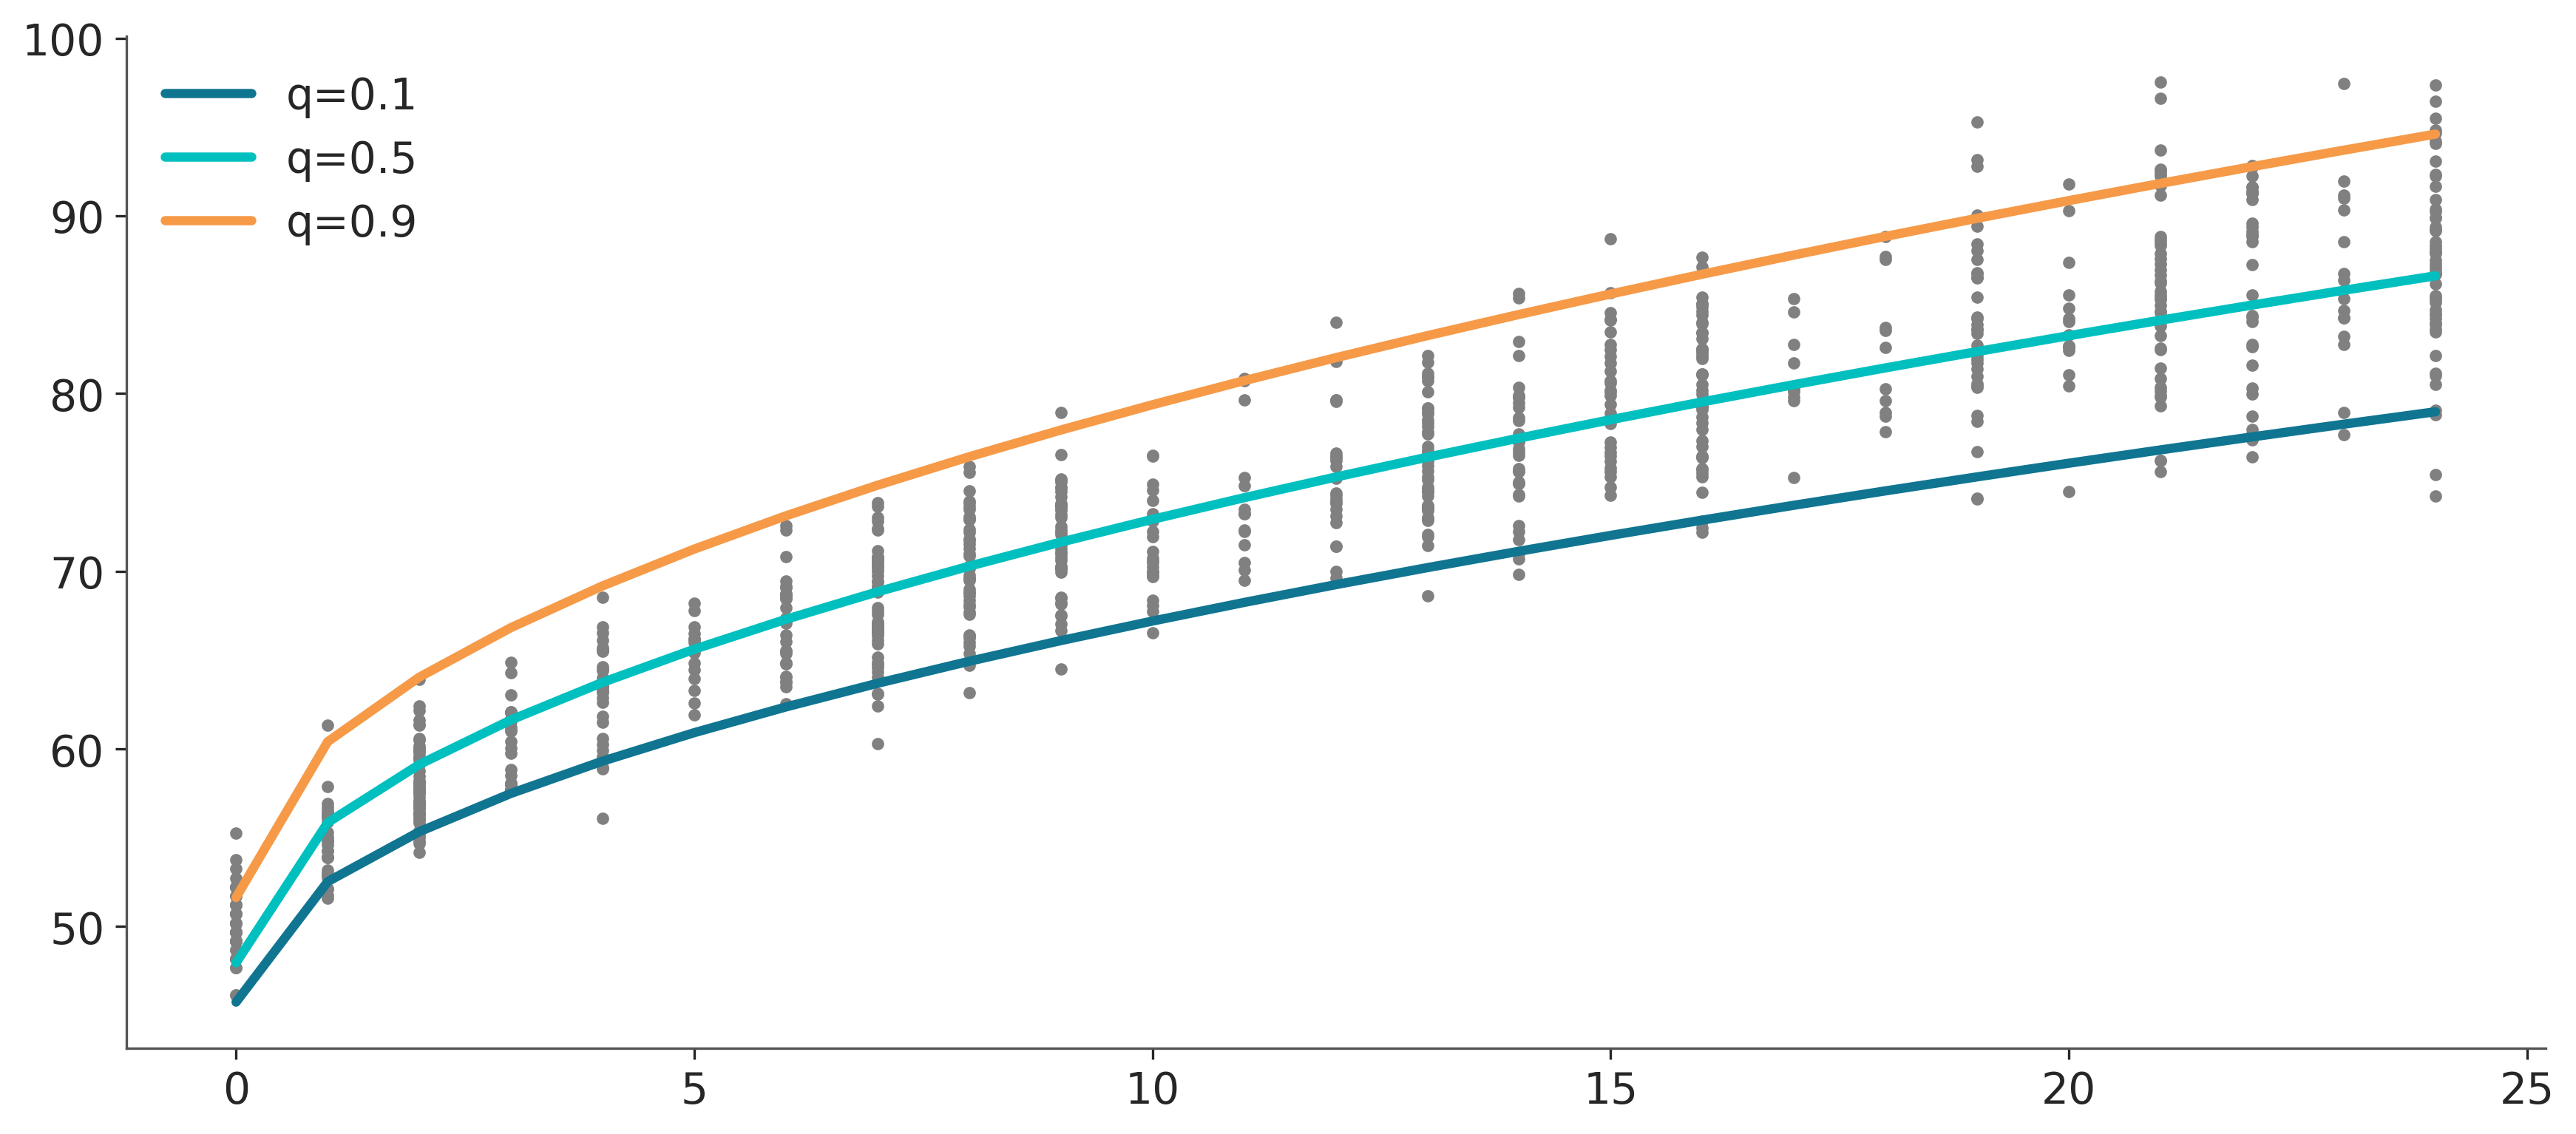

In [31]:
plt.plot(data.Meses, data.Longitud, ".", color="0.5")
for idx, label in enumerate(("q=0.1", "q=0.5", "q=0.9")):
    plt.plot(data.Meses.values, idata_q.posterior["μ"].mean(("chain", "draw"))[:,idx],
            label=label, lw=3);
    
plt.legend(); # depending on the quantile, it focus more on high/low values

## Hierarchical Linear Regression
- Allows models to make inference at subgroup/group level
- Problems
  - If there are divergences, increase target accept
  - If this does not work, have to reparametrize
- Divergences are common with hierarchical models
- Instead of defining $\beta = N(\beta_{\mu},\beta_{\sigma})$, we can define as $\beta = \beta_{\mu} + \beta_{offset}*\beta{\sigma}$, where $\beta_{offset}$
- Difference is that in the first case, the slope of each group is modelled explicitly while the second is the deviation from the common value ($\beta_{\mu}$)

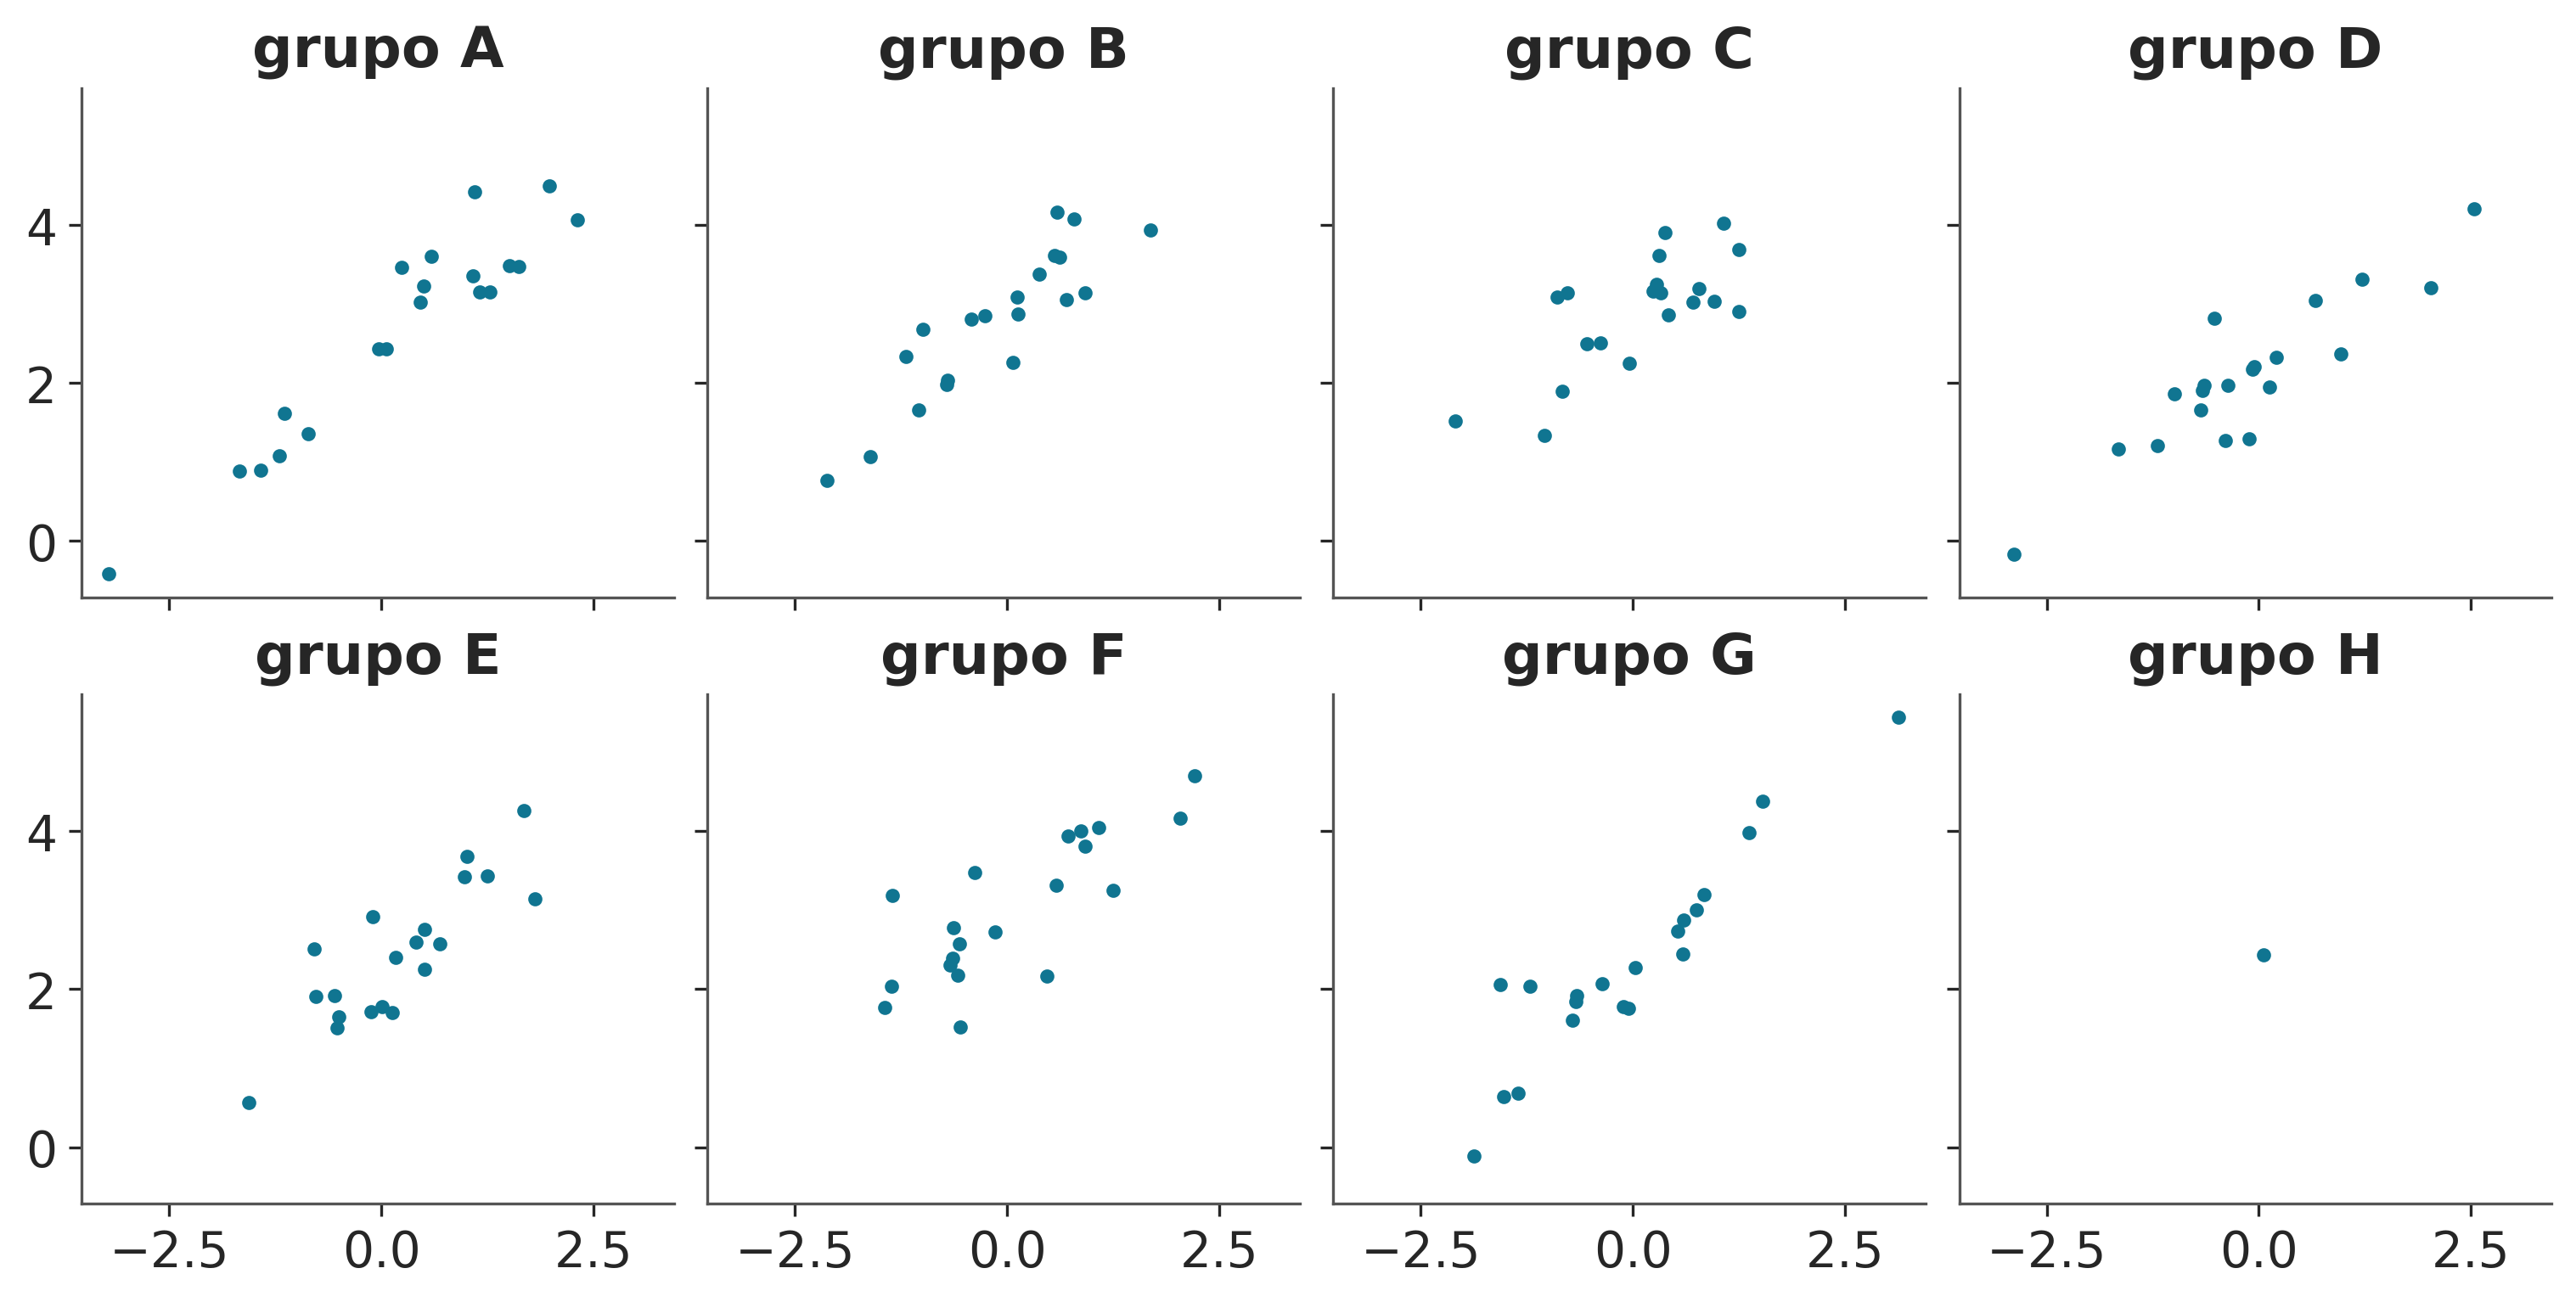

In [32]:
N = 20
grupos = ["A", "B", "C", "D", "E", "F", "G", "H"]
M = len(grupos)
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(0, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i, g in enumerate(grupos):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_title(f"grupo {g}")
    j += N
    k += N

In [33]:
coords = {"grupo": grupos}

with pm.Model(coords=coords) as hierarchical_model:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1) # 
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="grupo")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="grupo")
    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_hm = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [34]:
with pm.Model(coords=coords) as non_centered_hierarc:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="grupo")

    β_offset = pm.Normal("β_offset", mu=0, sigma=1, dims="grupo")
    β = pm.Deterministic("β", β_μ + β_offset * β_σ, dims="grupo")

    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_nch = pm.sample(target_accept=0.85, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β_offset, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


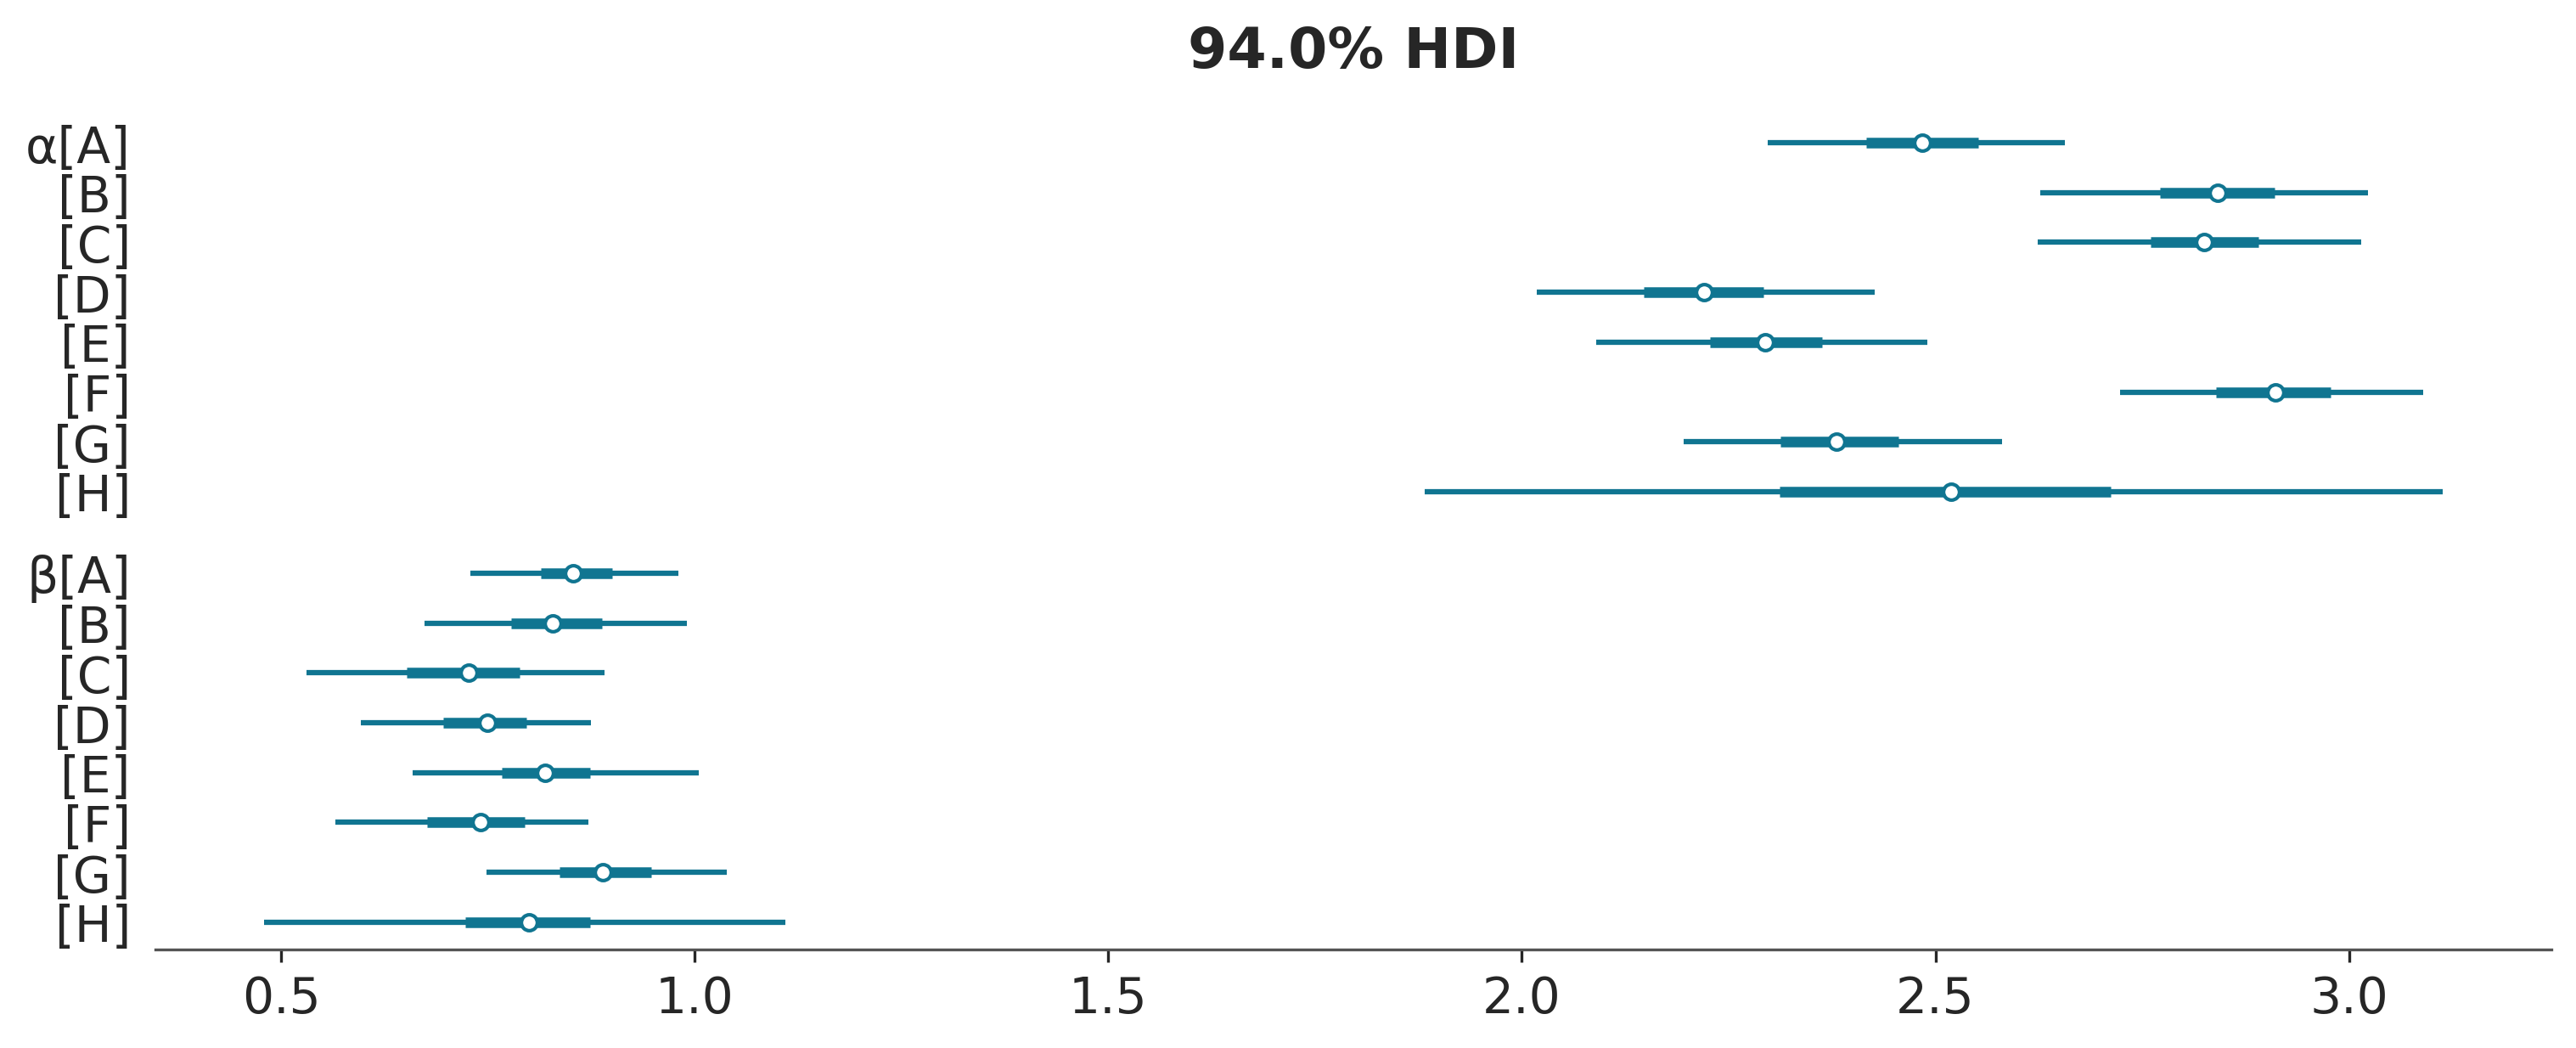

In [35]:
az.plot_forest(idata_nch, var_names=['α', 'β'], figsize=(10, 4), combined=True);

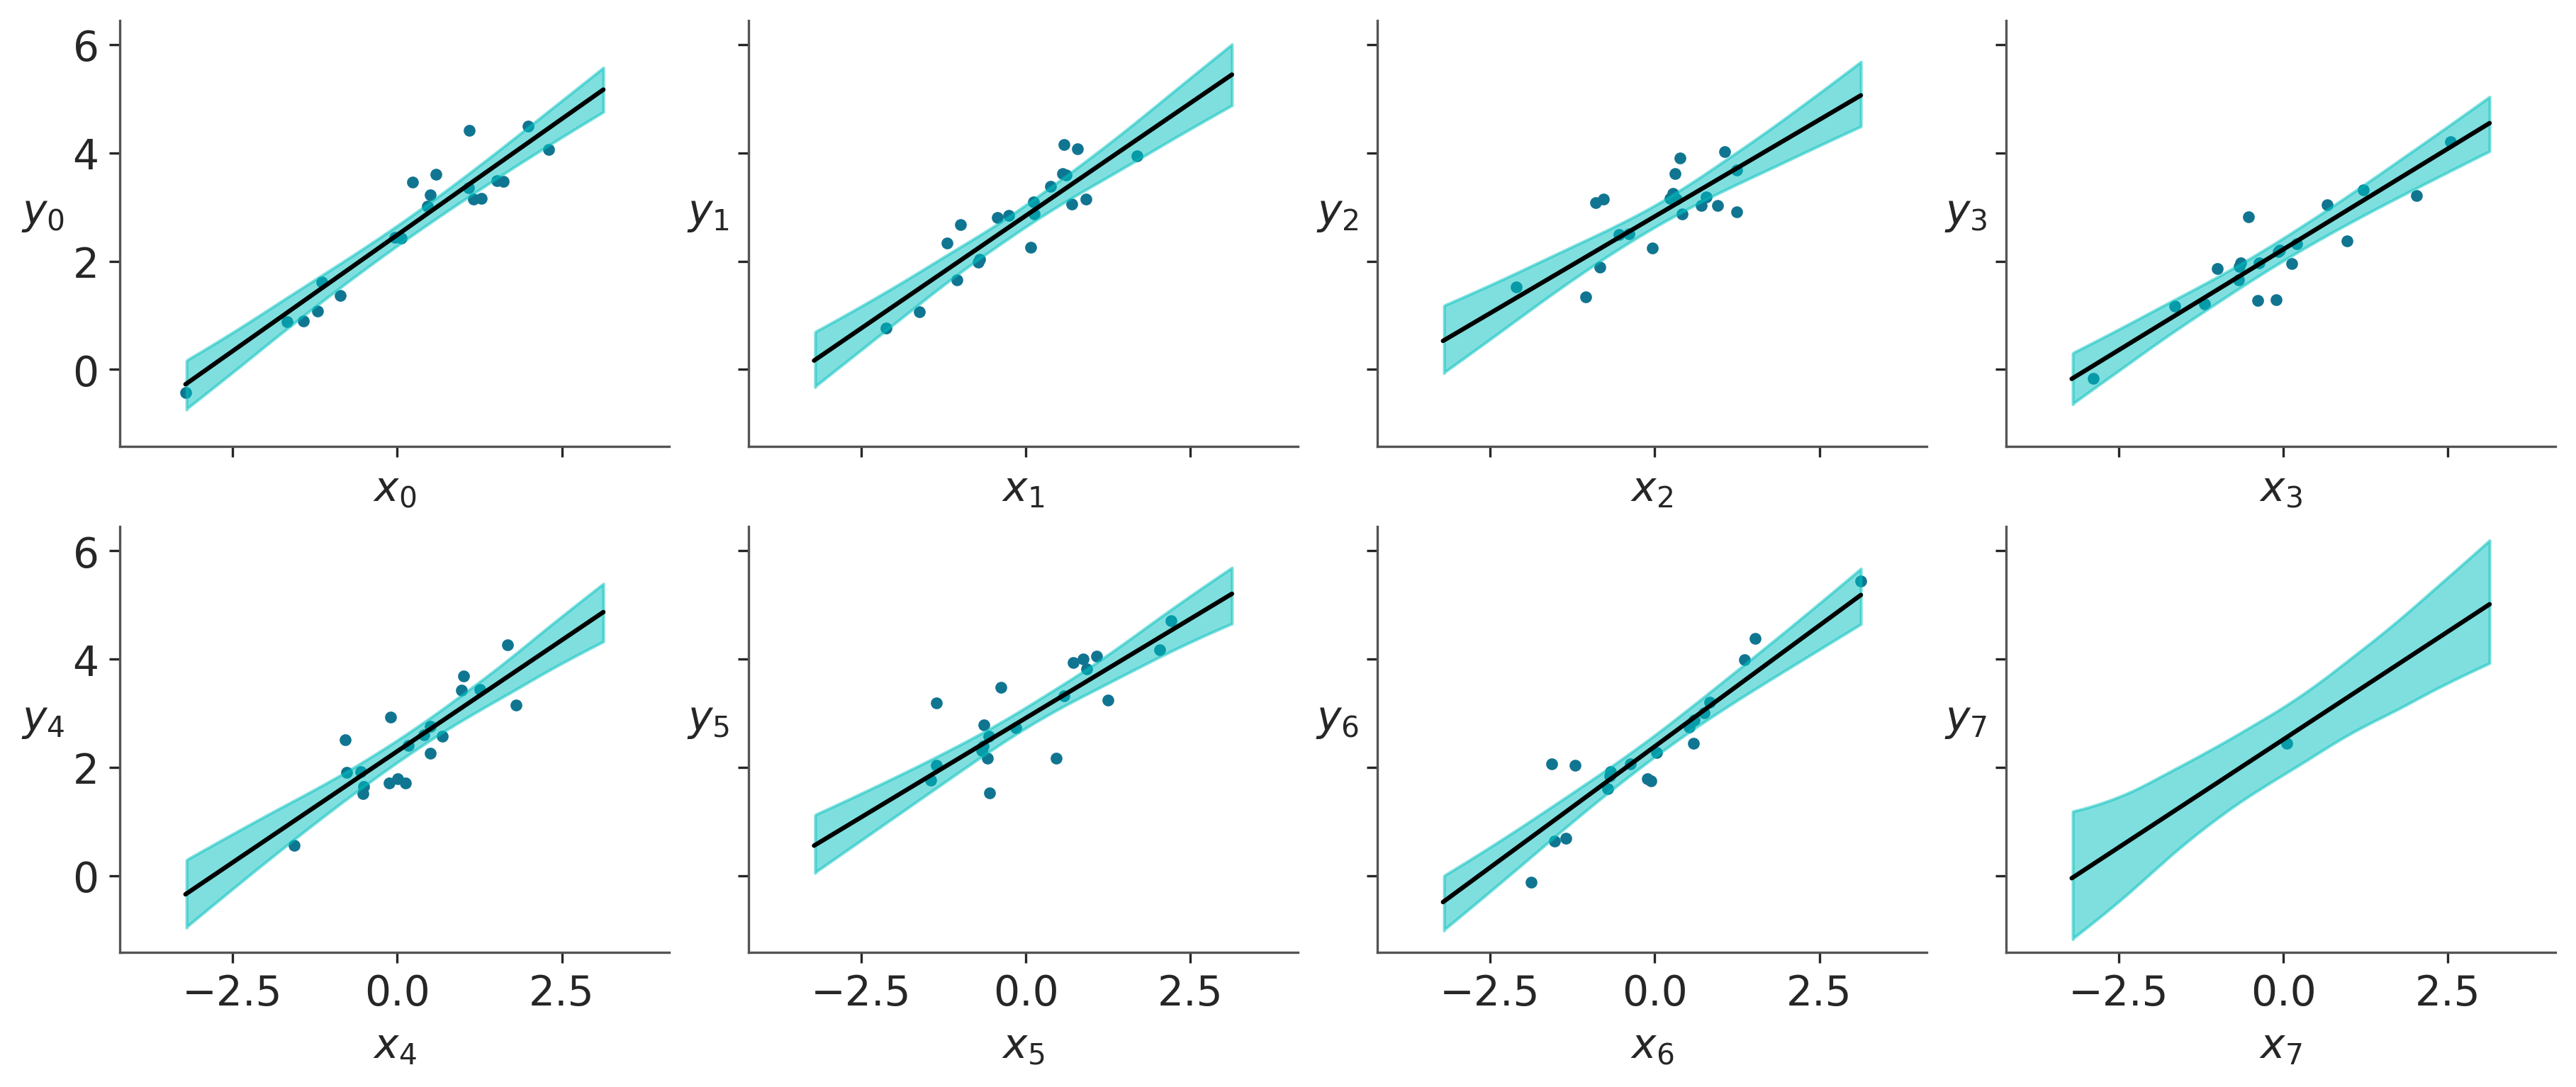

In [36]:
_, ax = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
posterior = az.extract(idata_nch)

for i, g in enumerate(grupos):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_xlabel("$x_{}$".format(i))
    ax[i].set_ylabel("$y_{}$".format(i), labelpad=10, rotation=0)
    alfas = posterior["α"].sel(grupo=g)
    betas = posterior["β"].sel(grupo=g)
    alfa_m = alfas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    ax[i].plot(x_range, alfa_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alfas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    plt.xlim(x_m.min() - 1, x_m.max() + 1)
    plt.ylim(y_m.min() - 1, y_m.max() + 1)
    j += N
    k += N